# Comparing Classification Models: Applying McNemar’s Test to Support Data Driven Model Selection 

## Overview

This notebook is the final deliverable for the capstone, "Comparing Classification Models: Applying McNemar’s Test to Support Data Driven Model Selection." It encompasses the code for the entire analysis process, from data acquisition to model training and statistical analysis.

While the external dataset described below was used to train all of the machine learning models that are compared later, this dataset itself is not very significant to the end result and purpose of this project. The data that really matters is produced during model training, and will be transformed for use in McNemar's test in the final stage of the analysis.

### Project Stages

1. Data Acquisition
2. Data Assessment
3. Data Cleaning
4. Model Training and Selection
5. Statistical Analysis of Model Performance

## External Dataset Used for Model Training

Looking at the Kaggle dataset [Realistic Loan Approval Dataset | US & Canada](https://www.kaggle.com/datasets/parthpatel2130/realistic-loan-approval-dataset-us-and-canada/data) for its major features, and preparing it for classification.


## Description of dataset from Author

1️⃣ Real-World Approval Logic The dataset implements actual banking criteria:

 - DTI ratio > 50% = automatic rejection
 - Defaults on file = instant reject
 - Credit score bands match real lending thresholds
 - Employment verification for loans ≥$20K


2️⃣ Realistic Correlations

 - Higher income → Better credit scores
 - Older applicants → Longer credit history
 - Students → Lower income, special treatment for small loans
 - Loan intent affects approval (Education best, Debt Consolidation worst)


3️⃣ Product-Specific Rules

 - Cards: More lenient, higher limits
 - Personal Loans: Standard criteria, up to $100K
 - Line of Credit: Capped at $50K, manual review for high amounts


4️⃣ Edge Cases Included

 - Young applicants (age 18) building first credit
 - Students with thin credit files
 - Self-employed with variable income
 - High debt-to-income ratios
 - Multiple delinquencies

In [1]:
# Python 3 Standard Library
from itertools import combinations
import os
from pathlib import Path
import re

# if you are re-running this on your system, you'll probably need to change this path to match where you are storing these files
PROJECT_ROOT_PATH = Path(f"{os.environ['USERPROFILE']}\\OneDrive\\Education\\WGU\\Capstone")

# making sure I'm in the right directory for EDA, need to be in root
if not re.match(r'.*Capstone$', os.getcwd()):
    os.chdir(PROJECT_ROOT_PATH)

# Data Science Modules
## Data Analytics and Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

## Machine Learning
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning, UndefinedMetricWarning, NotFittedError
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Statistical Analysis
from mlxtend.evaluate import mcnemar_table
from statsmodels.stats.contingency_tables import mcnemar

# Custom modules
from src.utilities import new_logger, save_atomic

# Setting Pandas DataFrame options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

This is a module-wide logger that is tied to this notebook. During operation, it may also trigger writes to `logs/src.utilities.log` when using `src.utilities` functions.

In [2]:
logger = new_logger("analysis", "logs")

## 1. Data Acquisition

This dataset was downloaded locally as a CSV file.

I'm being careful to use `Path` in order to create absolute references to files on disk. This will help prevent odd behavior for relative references when run on other operating systems.

In [3]:
# Fetch local dataset
data_path = Path('data/Loan_approval_data_2025.csv').resolve()
logger.info(f"Attempting to fetch data from '{data_path}'")

loan_appr_df = pd.read_csv(data_path)
logger.info(f"Successfully created DataFrame {loan_appr_df.shape}")

In [4]:
# Deliverable 1.1.1
# saving original in Parquet format
orig_data_path_parquet = save_atomic(loan_appr_df, Path("data/loan_approval_data_2025.orig.parquet"), fmt="parquet")

## 2. Data Assessment

### Tabular Assessment (Directed and Non-Directed)

During this part of the process I am looking for multiple issues common to datasets from the Internet:
- Missing data
- Malformed data/typos
- Improper data ranges
- Improper data types

The first section deals with looking for missing data and improper dtypes, then we move on to looking at the correlations between numeric features as well as their distributions.

In [5]:
loan_appr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amount           

There doesn't seem to be any missing data. This makes sense because this is a synthetic dataset, though it is based on realistic business rules surrounding approving or denying loans.

In [6]:
loan_appr_df.isna().sum()

customer_id                0
age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64

Now I'll look for duplicated rows within the dataset. Since this is synthetically generated data, I don't expect to see any duplicated rows. This will exclude the `customer_id` column since that column will make each row unique by default.

A value of 0 indicates that there are not duplicated rows.

In [7]:
loan_appr_df.drop(columns=['customer_id']).duplicated().sum()

np.int64(0)

In [8]:
loan_appr_df.describe()

age  years_employed  annual_income  credit_score  \
count  50000.000000    50000.000000   50000.000000  50000.000000   
mean      34.957060        7.454868   50062.892040    643.614820   
std       11.118603        7.612097   32630.501014     64.731518   
min       18.000000        0.000000   15000.000000    348.000000   
25%       26.000000        1.300000   27280.500000    600.000000   
50%       35.000000        4.900000   41607.500000    643.000000   
75%       43.000000       11.400000   62723.250000    687.000000   
max       70.000000       39.900000  250000.000000    850.000000   

       credit_history_years  savings_assets   current_debt  defaults_on_file  \
count          50000.000000    50000.000000   50000.000000      50000.000000   
mean               8.168274     3595.619400   14290.442220          0.053480   
std                7.207552    13232.399398   13243.757493          0.224991   
min                0.000000        0.000000      60.000000          0.000000   
25%                2.000000      130.000000    5581.000000          0.000000   
50%                6.100000      568.000000   10385.000000          0.000000   
75%               12.600000     2271.000000   18449.250000          0.000000   
max               30.000000   300000.000000  163344.000000          1.000000   

       delinquencies_last_2yrs  derogatory_marks    loan_amount  \
count              50000.00000      50000.000000   50000.000000   
mean                   0.55464          0.147640   33041.874000   
std                    0.84505          0.412996   26116.185102   
min                    0.00000          0.000000     500.000000   
25%                    0.00000          0.000000   12300.000000   
50%                    0.00000          0.000000   26100.000000   
75%                    1.00000          0.000000   48500.000000   
max                    9.00000          4.000000  100000.000000   

       interest_rate  debt_to_income_ratio  loan_to_income_ratio  \
count   50000.000000          50000.000000          50000.000000   
mean       15.498591              0.285724              0.701999   
std         4.067942              0.159787              0.465788   
min         6.000000              0.002000              0.008000   
25%        12.180000              0.161000              0.333000   
50%        15.440000              0.265000              0.622000   
75%        18.870000              0.389000              1.010250   
max        23.000000              0.800000              2.001000   

       payment_to_income_ratio   loan_status  
count             50000.000000  50000.000000  
mean                  0.233995      0.550460  
std                   0.155268      0.497452  
min                   0.003000      0.000000  
25%                   0.111000      0.000000  
50%                   0.207000      1.000000  
75%                   0.337000      1.000000  
max                   0.667000      1.000000

The basic descriptive statistics for each numeric columns look reasonable based on my knowledge of each of these columns.

Now I'll do a non-directed assessment of the head, tail, and a random sample of rows within the dataset. This is an attempt to look for consistency throughout the data. I am also looking for situations where the columns should be joined, melted, or otherwise engineered to produce a better analysis.

In [9]:
loan_appr_df.head(25)

customer_id  age occupation_status  years_employed  annual_income  \
0   CUST100000   40          Employed            17.2          25579   
1   CUST100001   33          Employed             7.3          43087   
2   CUST100002   42           Student             1.1          20840   
3   CUST100003   53           Student             0.5          29147   
4   CUST100004   32          Employed            12.5          63657   
5   CUST100005   32          Employed            13.4          32015   
6   CUST100006   53          Employed            22.9          44989   
7   CUST100007   44     Self-Employed             4.2          80603   
8   CUST100008   29          Employed             5.9          28416   
9   CUST100009   41          Employed             7.0          70717   
10  CUST100010   29          Employed             5.0          15000   
11  CUST100011   29           Student             1.3          17029   
12  CUST100012   37          Employed             1.3          49084   
13  CUST100013   18          Employed             0.0          55958   
14  CUST100014   18     Self-Employed             1.0          99020   
15  CUST100015   28          Employed             0.4          59609   
16  CUST100016   22     Self-Employed             1.0          82604   
17  CUST100017   38          Employed             5.3          53356   
18  CUST100018   24          Employed             5.4          18675   
19  CUST100019   18     Self-Employed             1.0          55309   
20  CUST100020   52          Employed            31.3          75932   
21  CUST100021   32          Employed             1.3         109702   
22  CUST100022   35          Employed            16.9          68117   
23  CUST100023   18           Student             0.3          33556   
24  CUST100024   28     Self-Employed             5.4          59899   

    credit_score  credit_history_years  savings_assets  current_debt  \
0            692                   5.3             895         10820   
1            627                   3.5             169         16550   
2            689                   8.4              17          7852   
3            692                   9.8            1480         11603   
4            630                   7.2             209         12424   
5            570                   7.3             253          1120   
6            674                  11.1           19667         19298   
7            625                  18.5             830         38382   
8            569                   2.6            1334         22668   
9            638                  21.5            1578         21394   
10           657                   8.9            2105          3866   
11           668                   4.3             215          5592   
12           580                  11.3            1289         21106   
13           681                   1.4             378         14090   
14           561                   1.6             538         13733   
15           654                   2.6             881          9183   
16           605                   3.5            9216         16116   
17           671                  19.8            6339         23085   
18           531                   3.3              11          3280   
19           597                   1.5             346          2930   
20           695                   2.1            1283         10655   
21           720                  10.4            2790         42534   
22           698                  16.3             549         20450   
23           574                   1.5              91         10727   
24           567                   3.2           20476         27393   

    defaults_on_file  delinquencies_last_2yrs  derogatory_marks  \
0                  0                        0                 0   
1                  0                        1                 0   
2                  0                        0           

In [10]:
loan_appr_df.tail(25)

customer_id  age occupation_status  years_employed  annual_income  \
49975  CUST149975   21     Self-Employed             1.0          68454   
49976  CUST149976   38          Employed            10.3          27469   
49977  CUST149977   32          Employed             3.9          23132   
49978  CUST149978   53           Student             0.8          15000   
49979  CUST149979   18           Student             1.2          26627   
49980  CUST149980   35          Employed            10.5          28836   
49981  CUST149981   40     Self-Employed            16.2          36357   
49982  CUST149982   45           Student             0.1          27554   
49983  CUST149983   36          Employed             6.2          67472   
49984  CUST149984   39     Self-Employed             4.8         113630   
49985  CUST149985   37          Employed             1.9          28050   
49986  CUST149986   40          Employed             3.7          97505   
49987  CUST149987   34          Employed             5.3          32326   
49988  CUST149988   60           Student             1.2          67558   
49989  CUST149989   41          Employed            16.8          80369   
49990  CUST149990   37          Employed             9.4          37218   
49991  CUST149991   26          Employed             0.7          22159   
49992  CUST149992   30          Employed             9.3          24797   
49993  CUST149993   53          Employed            18.1          36948   
49994  CUST149994   18          Employed             0.0          64343   
49995  CUST149995   35          Employed             4.3          39449   
49996  CUST149996   34          Employed             4.4          20496   
49997  CUST149997   41     Self-Employed             4.8          18743   
49998  CUST149998   38           Student             0.4          17250   
49999  CUST149999   53          Employed            17.2          46923   

       credit_score  credit_history_years  savings_assets  current_debt  \
49975           552                   2.3            1371         24545   
49976           691                   8.5            2151         18801   
49977           560                  13.9             112          8077   
49978           591                  27.2             509          3882   
49979           546                   0.8              18          1634   
49980           524                   0.5              36          2558   
49981           601                  19.4            3526         22029   
49982           698                   9.6             665          1429   
49983           763                  10.6             264          5643   
49984           717                  10.8             422         37982   
49985           653                  18.6             476         15554   
49986           684                  13.9             854         33798   
49987           678                  14.7             585         12320   
49988           774                  13.4             647          2042   
49989           671                  14.2            2968         17515   
49990           588                  11.7            2389         13416   
49991           550                   3.7            1174         12699   
49992           610                   8.3              16          6282   
49993           676                   2.6              59         11421   
49994           585                   1.3             277         27914   
49995           570                  16.3            1127          7576   
49996           672                  12.6            1478          6276   
49997           719                  10.1              17         10331   
49998           633                   1.3               5          7779   
49999           695                  15.0            8332          2655   

       defaults_on_file  delinquencies_last_2yrs  derogatory_marks  \
49975                 0           

In [11]:
loan_appr_df.sample(25)

customer_id  age occupation_status  years_employed  annual_income  \
33782  CUST133782   35           Student             1.2          17880   
34984  CUST134984   32          Employed             4.0          45248   
23533  CUST123533   44          Employed            16.9          53281   
5377   CUST105377   18          Employed             0.0          33832   
20508  CUST120508   31          Employed             5.9          28775   
8563   CUST108563   37     Self-Employed            13.3         161871   
1173   CUST101173   34          Employed             2.8          66174   
36377  CUST136377   18          Employed             0.0          16398   
49383  CUST149383   20          Employed             0.8          22871   
7421   CUST107421   34     Self-Employed             3.1          53624   
17774  CUST117774   20     Self-Employed             1.0          93895   
42789  CUST142789   49          Employed            22.1          37397   
31704  CUST131704   34          Employed             9.2          25254   
45668  CUST145668   38           Student             1.6          15000   
27520  CUST127520   44          Employed            20.2          42407   
18690  CUST118690   25          Employed             4.8          49002   
26907  CUST126907   35          Employed            13.6          23049   
19304  CUST119304   45          Employed            24.7          54481   
39236  CUST139236   50          Employed            29.4          28202   
533    CUST100533   20           Student             1.4          53961   
39680  CUST139680   44          Employed            13.9          39848   
20028  CUST120028   34     Self-Employed             7.4         101205   
225    CUST100225   48     Self-Employed            22.8          33296   
31472  CUST131472   37          Employed            13.0          21151   
30260  CUST130260   25          Employed             4.7          42093   

       credit_score  credit_history_years  savings_assets  current_debt  \
33782           697                   9.9              25          2559   
34984           623                   9.5            5930         25064   
23533           693                  21.0             373         15349   
5377            667                   0.1               7          6185   
20508           633                  11.3             484          6787   
8563            564                  11.2            3724         17914   
1173            676                   4.8            1201         10787   
36377           667                   1.0              13          4473   
49383           698                   2.0             428           983   
7421            663                   5.5            2788           148   
17774           572                   1.9              76         15193   
42789           629                  26.5             530          4584   
31704           632                   9.2            3338          9932   
45668           683                   1.3             151          2126   
27520           686                   1.6              25         19366   
18690           568                   0.4             523         13826   
26907           627                   3.2            2055         14318   
19304           684                  25.2            4177         10111   
39236           731                   8.0            4606         11293   
533             655                   0.8             153          7558   
39680           582                  20.7             446         31878   
20028           677                   4.0             870         14427   
225             667                   6.4             196         10098   
31472           667                  16.2            4203          2912   
30260           620                   4.6             130         12956   

       defaults_on_file  delinquencies_last_2yrs  derogatory_marks  \
33782                 0           

### Exploratory Visualizations

First, I isolate the columns into their various types. Since there are so few `object` columns, I will create that column grouping first, and then use it to narrow down to the numeric types. For ease of analysis, I will make two separate numeric groupings - one with the target variable `loan_status` and one without.

Then, the `obj_cols` group will be examined for repeated values - this indicate a good candidate for a categorical column.

Next, the `num_cols` will be analyzed using a correlation heatmap to look at relationships among variables.

Finally, I will take a look at the distributions of the `num_cols` group to get a sense of how normal each distribution is, or whether it has unique characteristics such as discrete values, or bimodality.

In [12]:
# Categorical columns, currently represented as `object` (string) dtypes
obj_cols = [col for col in loan_appr_df.dtypes[loan_appr_df.dtypes == 'object'].index if col != 'customer_id']

# all numerical columns including the `loan_status` target variable
num_cols_with_target = loan_appr_df.drop(columns=obj_cols).drop(columns=['customer_id']).columns.values

# all numerical columns excluding the `loan_status` target variable
num_cols = loan_appr_df.drop(columns=obj_cols).drop(columns=['customer_id', 'loan_status']).columns.values

### Categorical Feature Exploration

Moving on to the object features, looking at the current possible values.

In [13]:
for col in obj_cols:
    print(f"{loan_appr_df[col].value_counts()}\n")

occupation_status
Employed         34971
Self-Employed    10179
Student           4850
Name: count, dtype: int64

product_type
Credit Card       22455
Personal Loan     17523
Line of Credit    10022
Name: count, dtype: int64

loan_intent
Personal              12429
Education             10134
Medical                7598
Business               7469
Home Improvement       7453
Debt Consolidation     4917
Name: count, dtype: int64



Based on what we can see above, these columns are all good candidates for becoming categorical. Let's look at the distributions of each feature to see if they make sense.

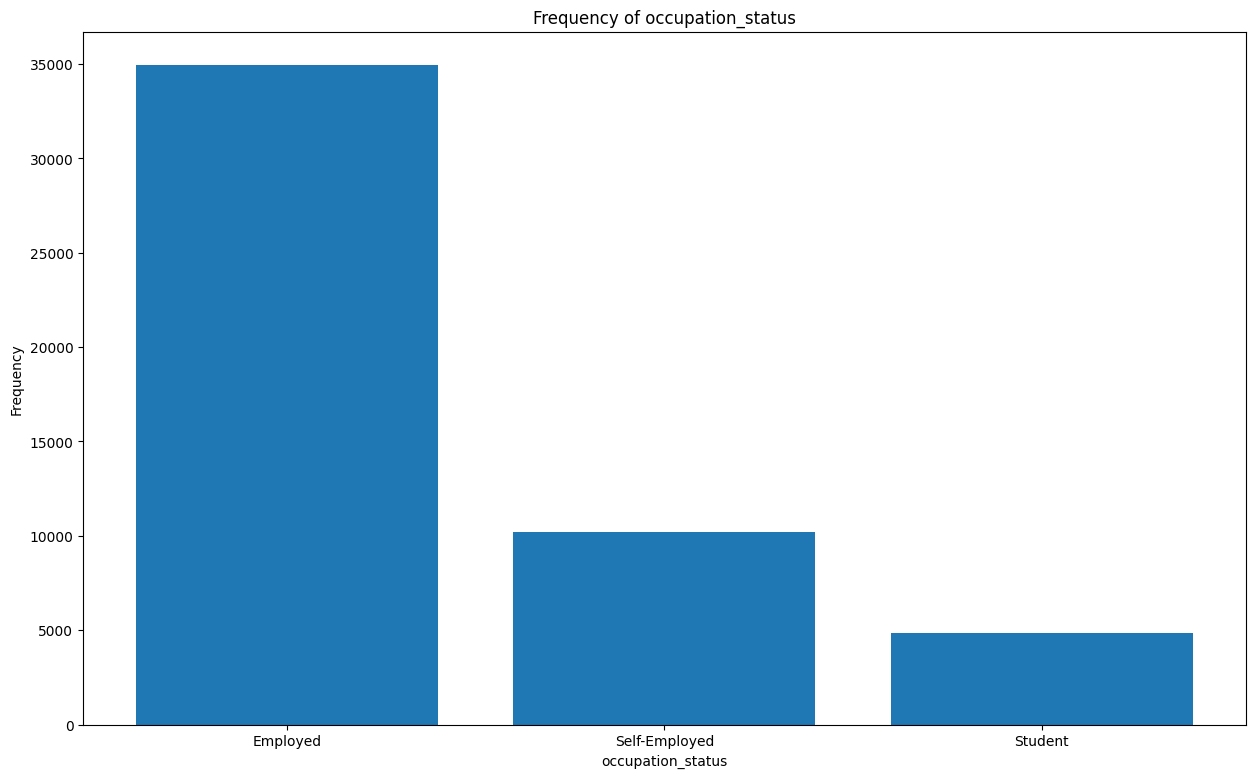

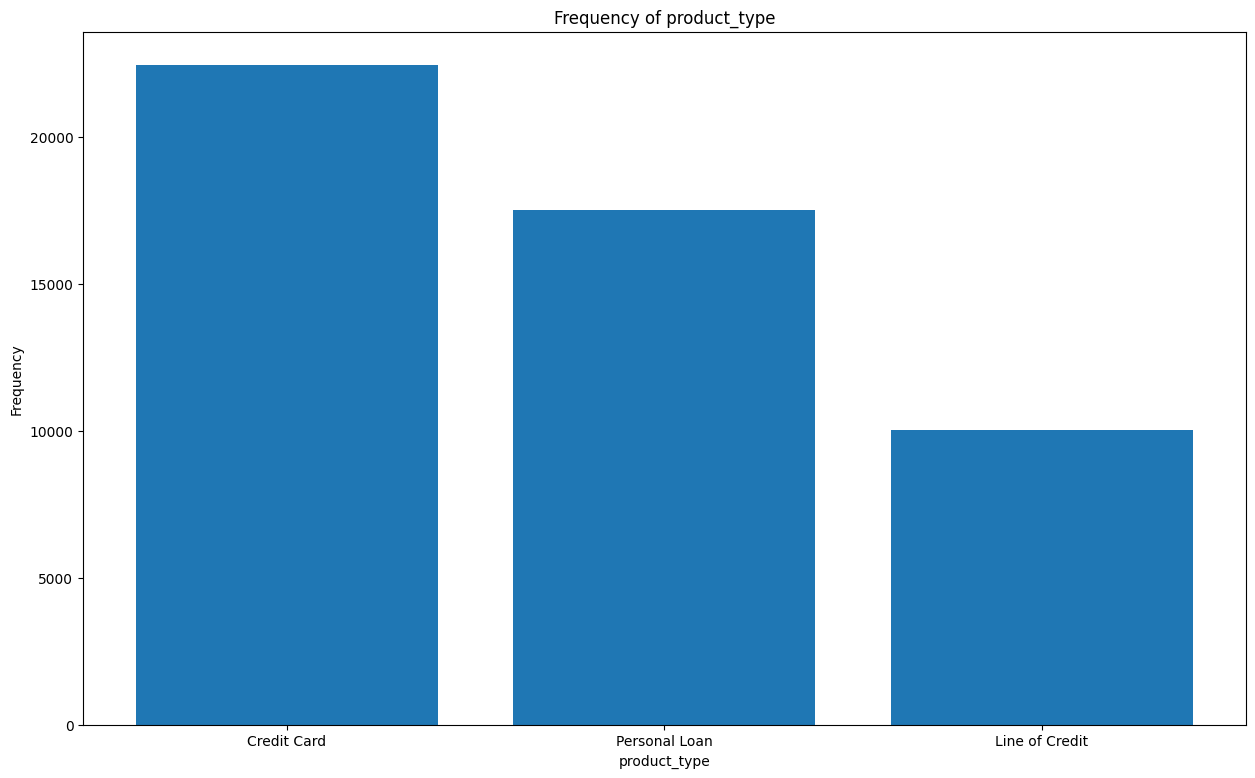

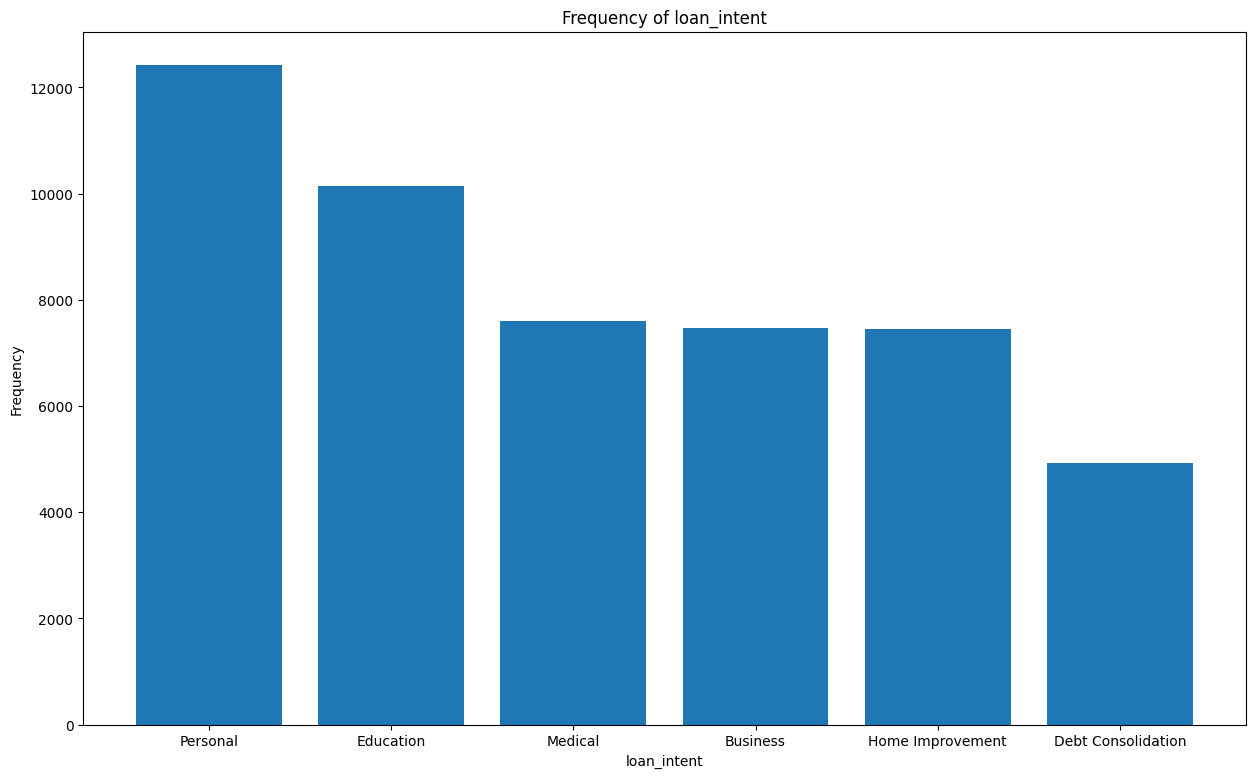

In [14]:
for col in obj_cols:
    val_counts = loan_appr_df[col].value_counts()
    fig, ax = plt.subplots(figsize=(15,9))
    ax.bar(val_counts.index.values, val_counts.values)
    ax.set_xlabel(val_counts.index.name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Frequency of {val_counts.index.name}")

These categories seem like they make sense, and no changes are needed. This is expected from a synthetic dataset.

### Numerical Feature Exploration

To explore the numerical features, first I wanted to examine the correlations between numeric variables, to see how each column relates to every other column.

The diagonal from top left to bottom right shows each column's correlation with itself, and so is expected to be perfect. Any other perfect or very high correlation needs to be examined.

A triangular mask was applied from the diagonal onwards to eliminate duplicate values from being displayed. This takes care of the diagonal issue, and allows us to focus only on values that actually matter.

Correlation matters because at least one of the models compared in this analysis relies on an assumption of feature independence (looking at you, Gaussian Naive Bayes). If that assumption can't be upheld due to high collinearity of features, then we either need to not consider models that are strongly affected, or determine if any features are redundant and need to be dropped.

In [15]:
# create a correlation matrix with all of the numeric values
correlation_matrix = loan_appr_df[num_cols_with_target].corr()

In [16]:
# masking the upper right half so we don't get repeats
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

Text(0.5, 1.0, 'Loan Application: Numeric Variables Correlation Heatmap')

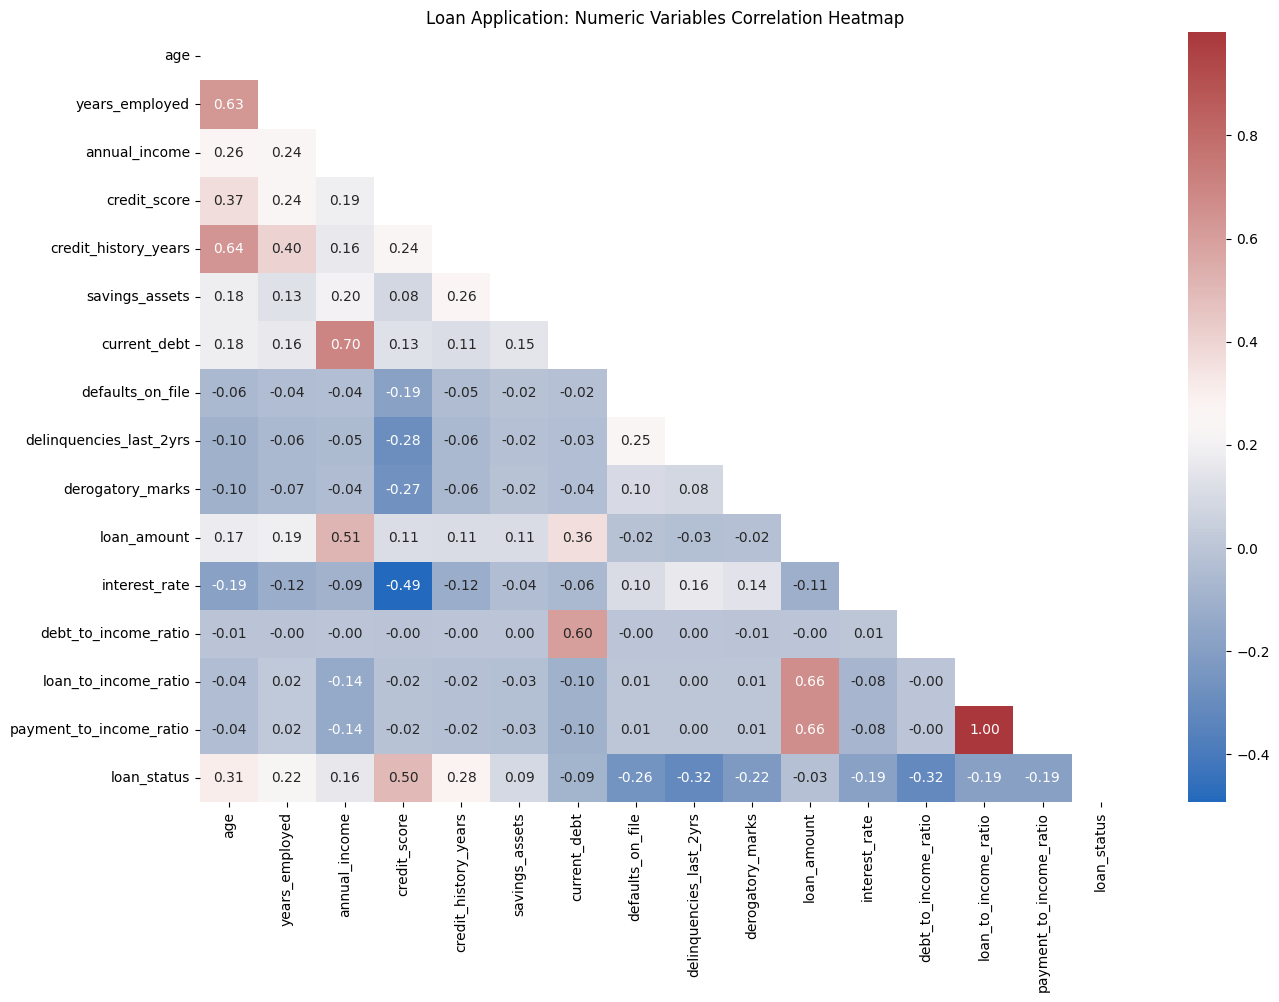

In [17]:
# create a Seaborn heatmap showing all of the correlation values
plt.figure(figsize=(15,10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="vlag",
    fmt=".2f",
    mask=mask
)
plt.title("Loan Application: Numeric Variables Correlation Heatmap")

Immediately, the relationship between the `loan_to_income_ratio` and `payment_to_income_ratio` jumps out from the heatmap. This perfect correlation makes sense as the **monthly payment (`payment_to_loan_ratio`)** would be perfectly, positively correlated with the **loan amount (`loan_to_income_ratio`)**, as the $payment = \frac{amount} {term}$. Due to this, `payment_to_income_ratio` will likely be dropped as it is a redundant column. If we were more interested in the effect of the specific monthly payment on the response variable, we could drop `loan_to_income_ratio` instead.

Moving on, we can summarize how each numeric variable varies against every other numeric variable using Seaborn's `pairplot()` function. I will take a look at each distribution individually as well, below.

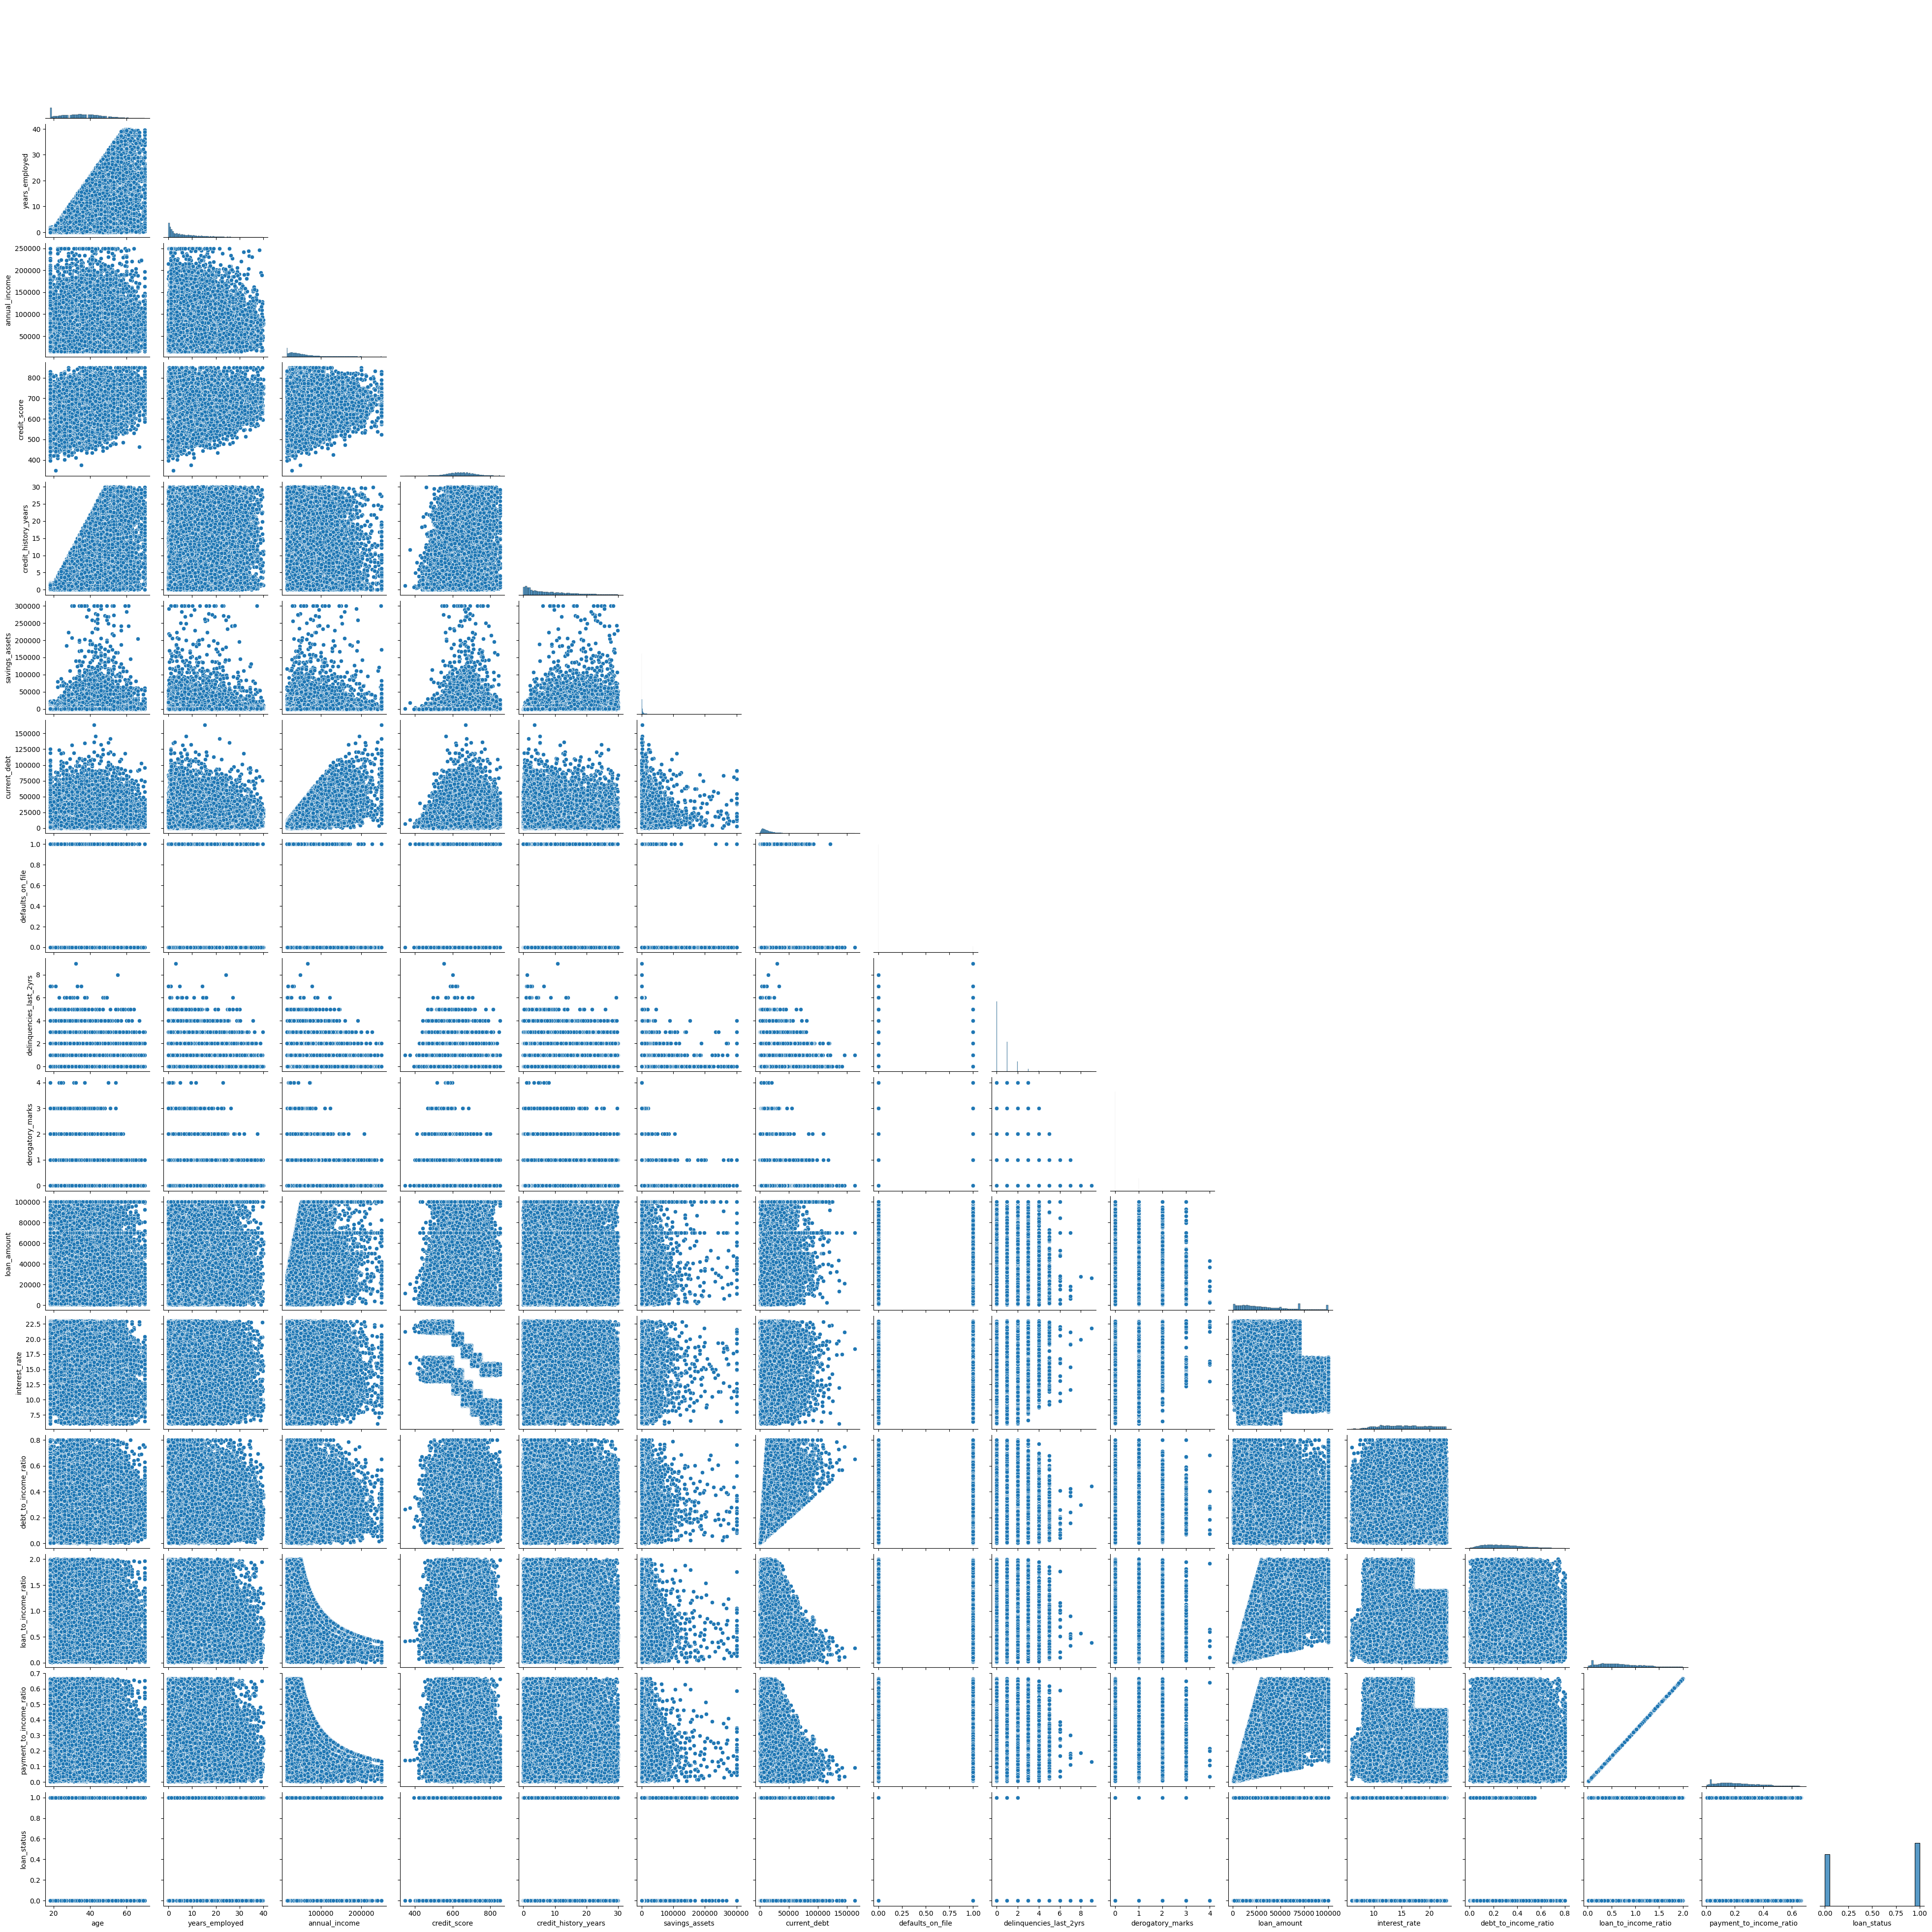

In [18]:
sns.pairplot(loan_appr_df[num_cols_with_target], corner=True)

The relationships are a bit hard to see, so it may be a good idea to move this image to another location where it can be enlarged.

Keep in mind that the **correlation coefficient** ($r^2$) should be viewed alongside the actual pairwise scatterplot for each column pairing so that the full picture of the data can be understood. For example, the relationship between `interest_rate` and `credit_score` shows to be a mildly negative correlation according to its $r^2 = -0.49$. However, when the scatterplot is viewed, it becomes understood that there is a business rule at play here that actually results in a descending step pattern with a inverse relationship between the `interest_rate` offered and the `credit_score` of the applicant. There is also a clear delineation between two different step values, which should make the analyst wonder if there are two sets of `interest_rates` that are split by some category.

This is just one example, I will leave it as an exercise for the reader to examine each scatterplot and compare it with its corresponding $r^2$ value.


Finally, to conclude the analysis of the numeric columns, I will examine each column's distribution of values to see what curves are at play, and whether those curves are reasonable.

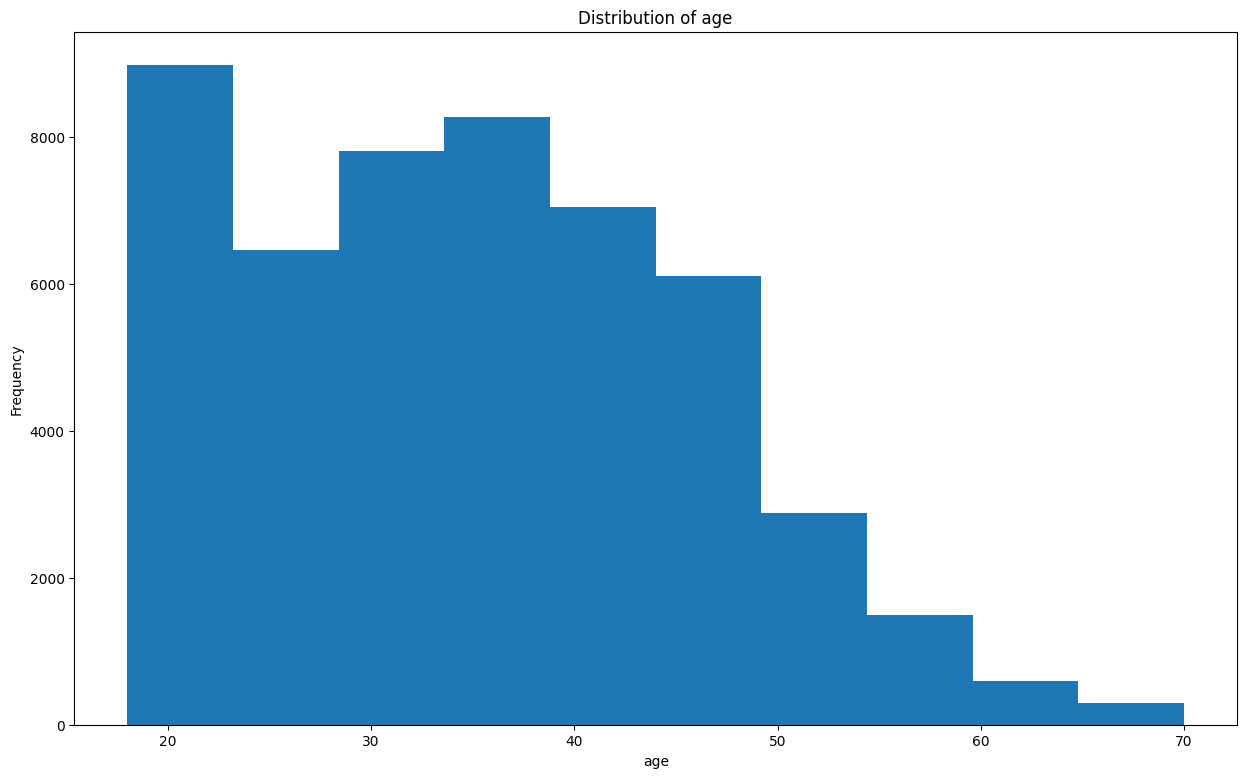

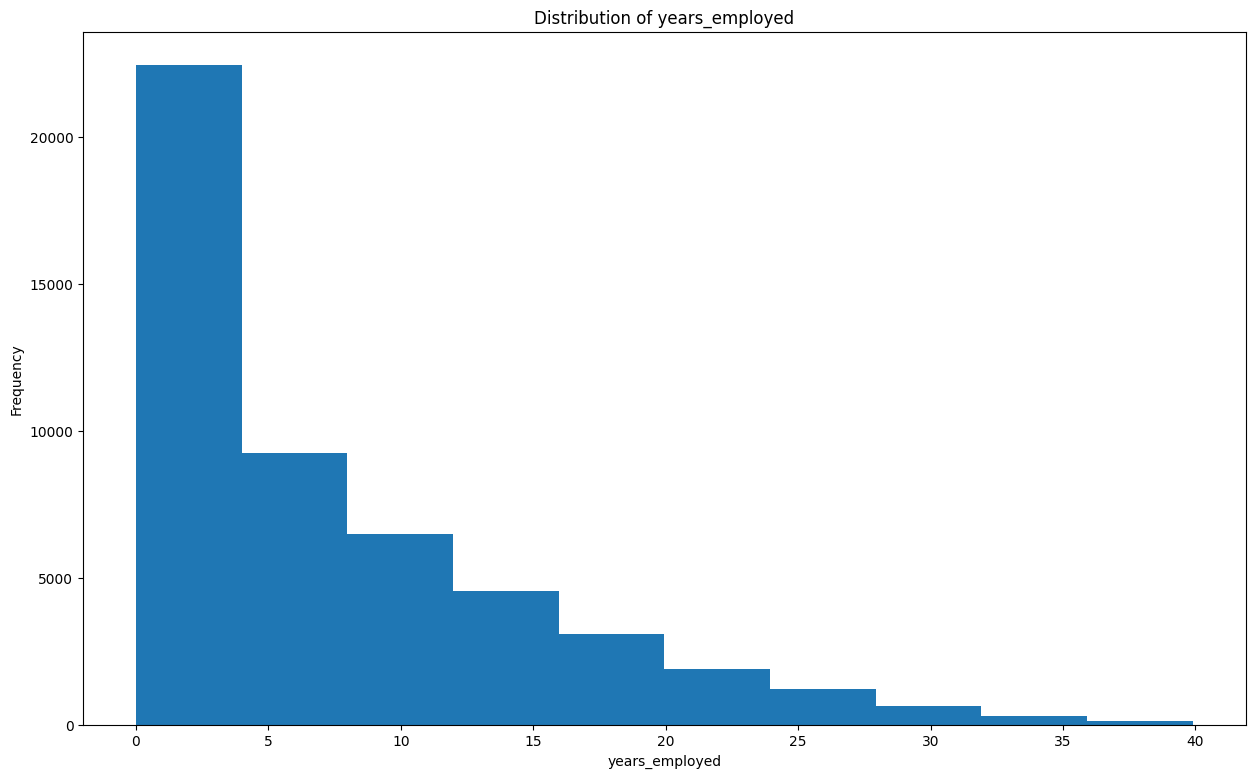

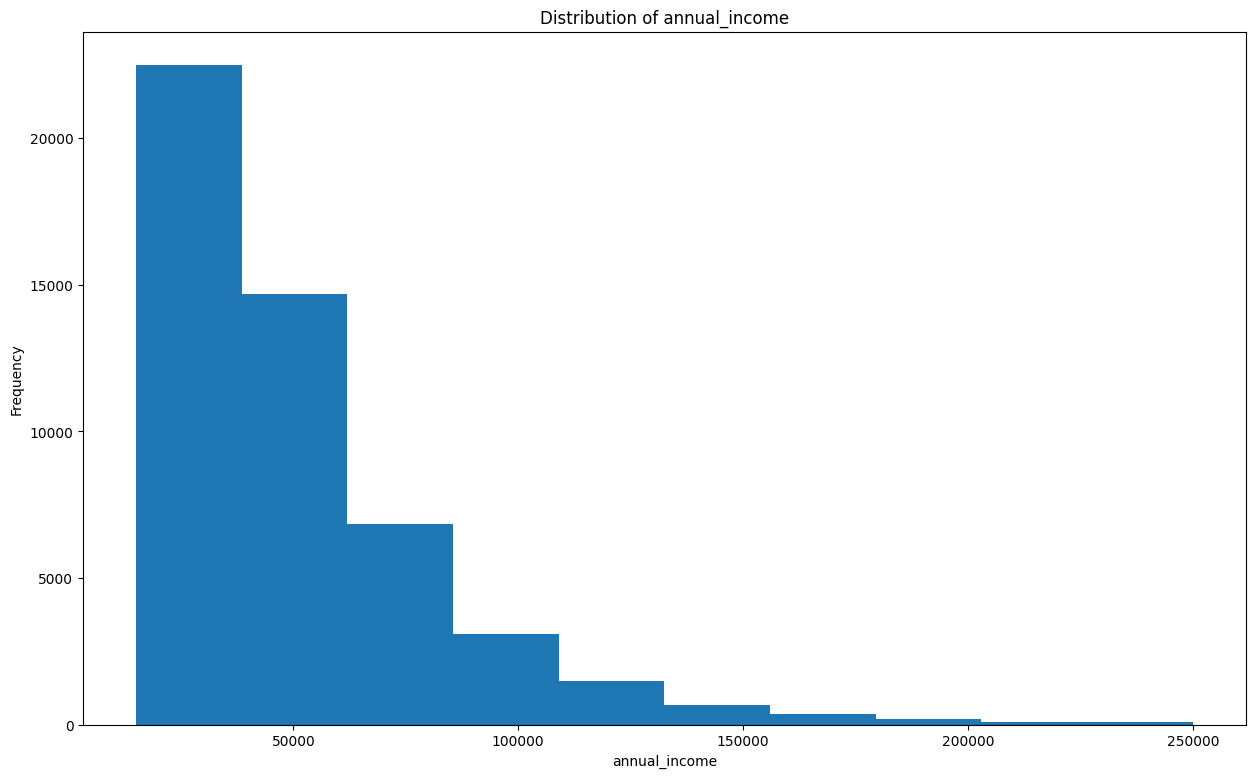

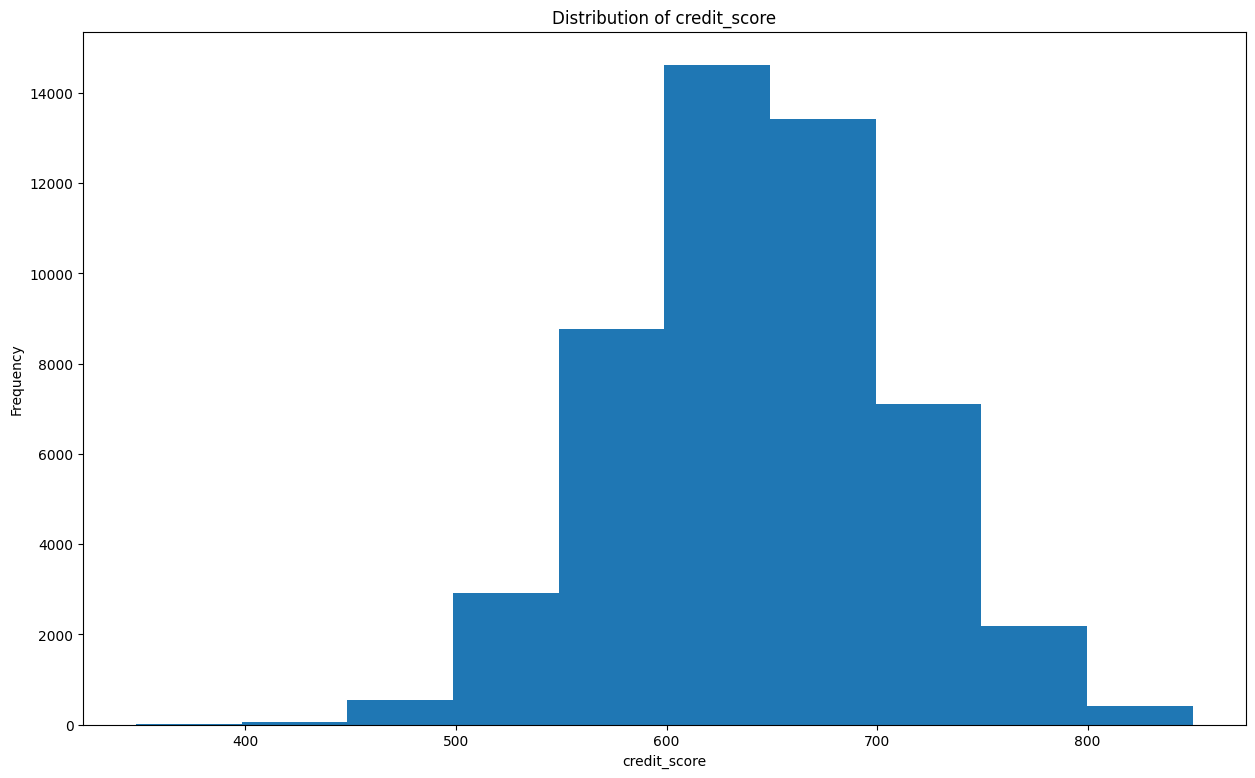

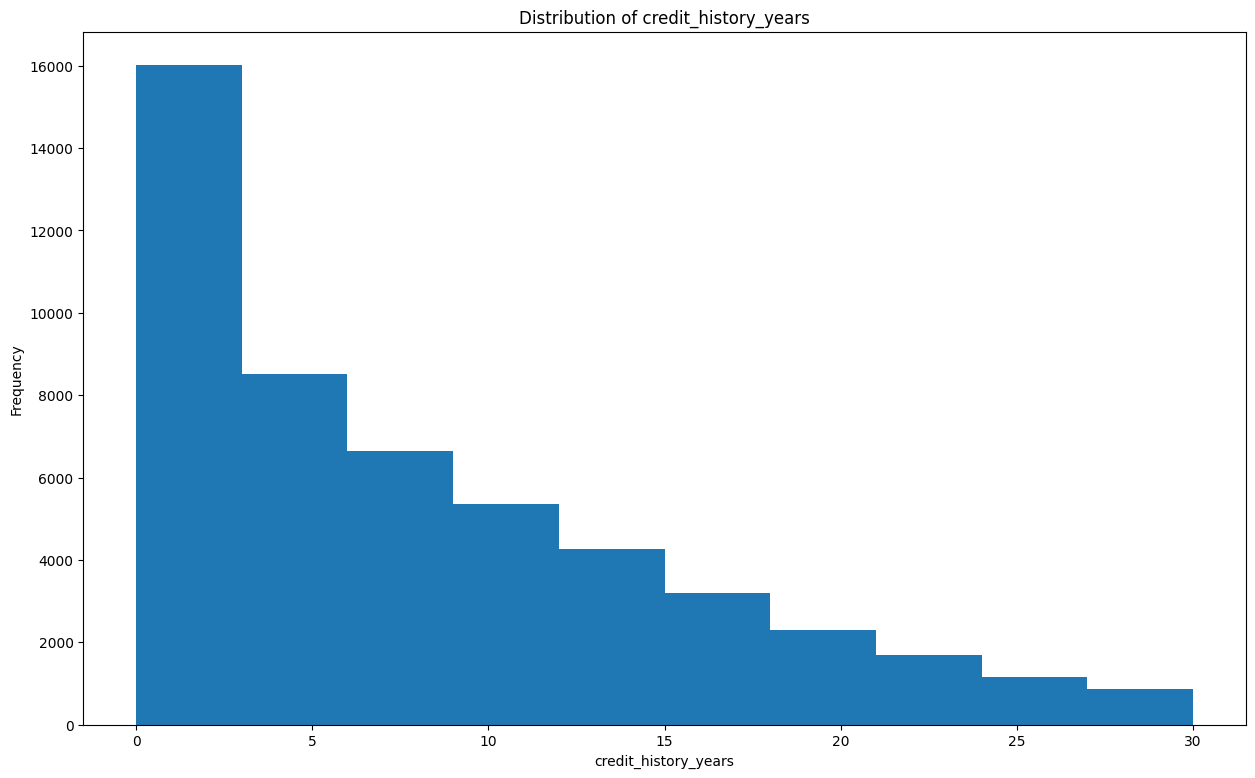

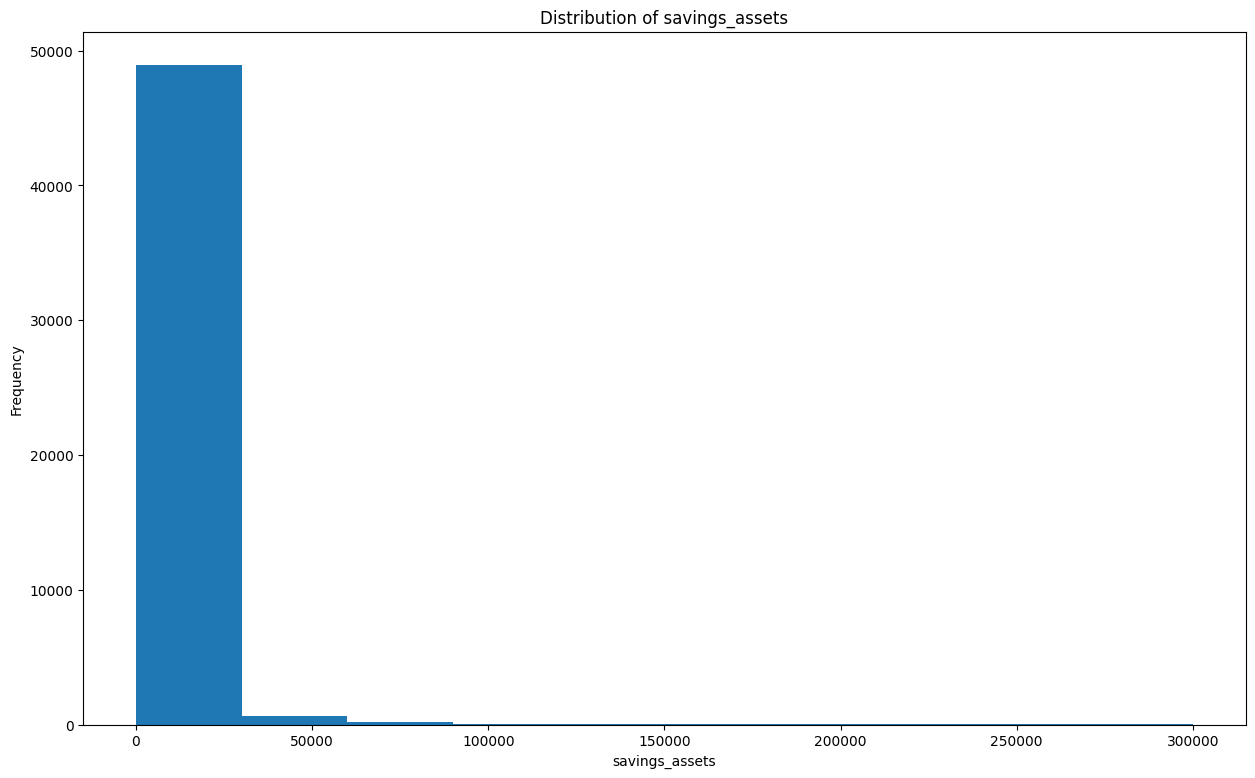

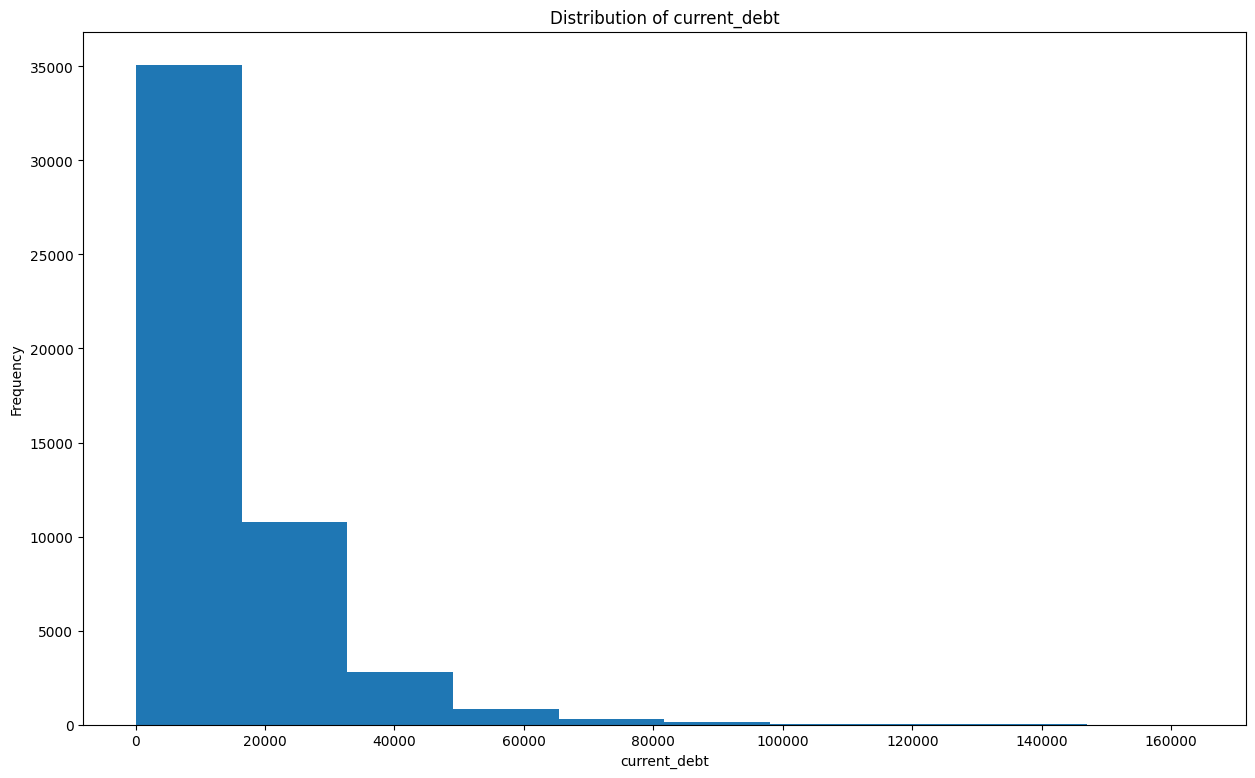

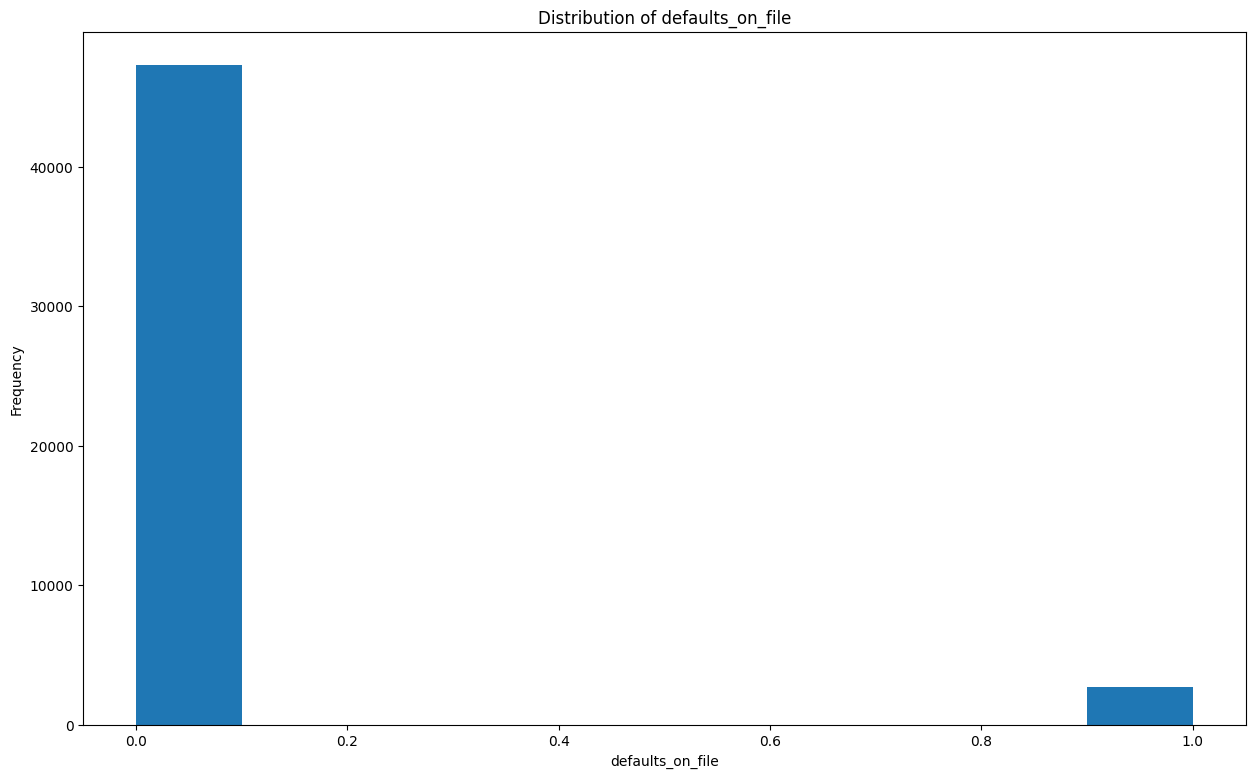

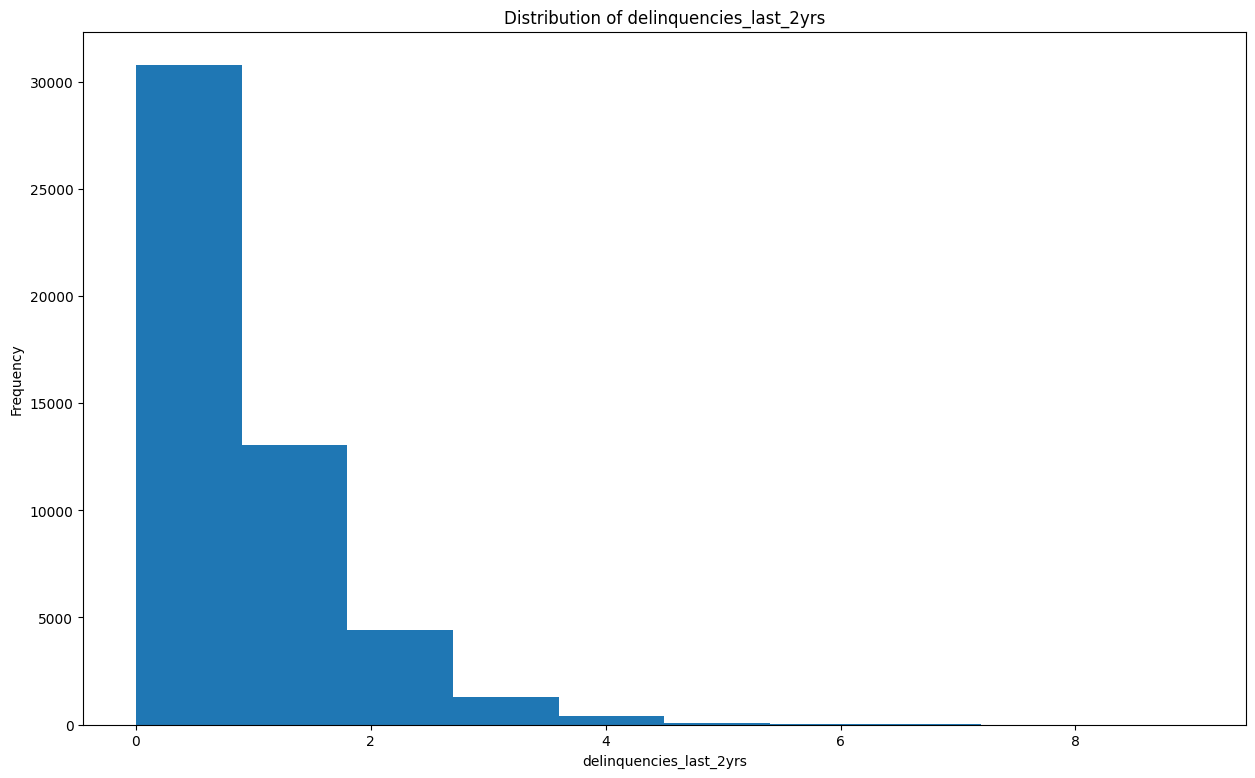

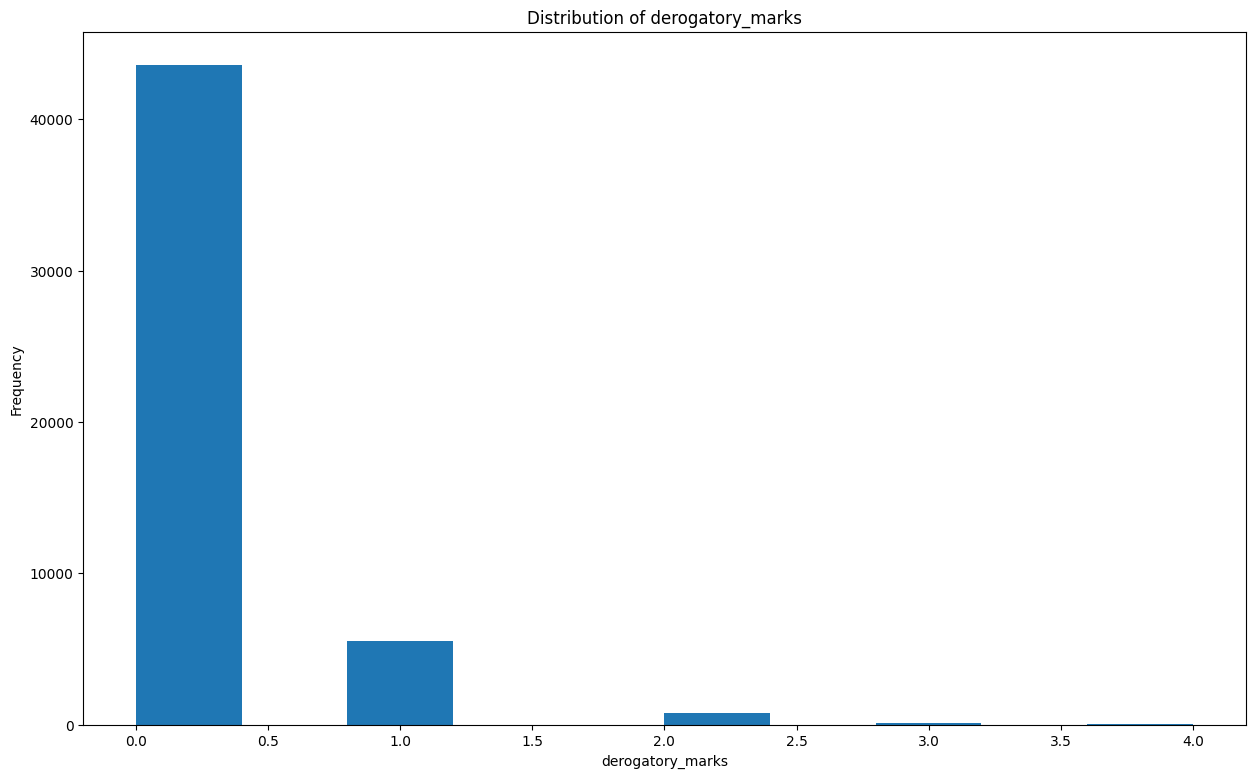

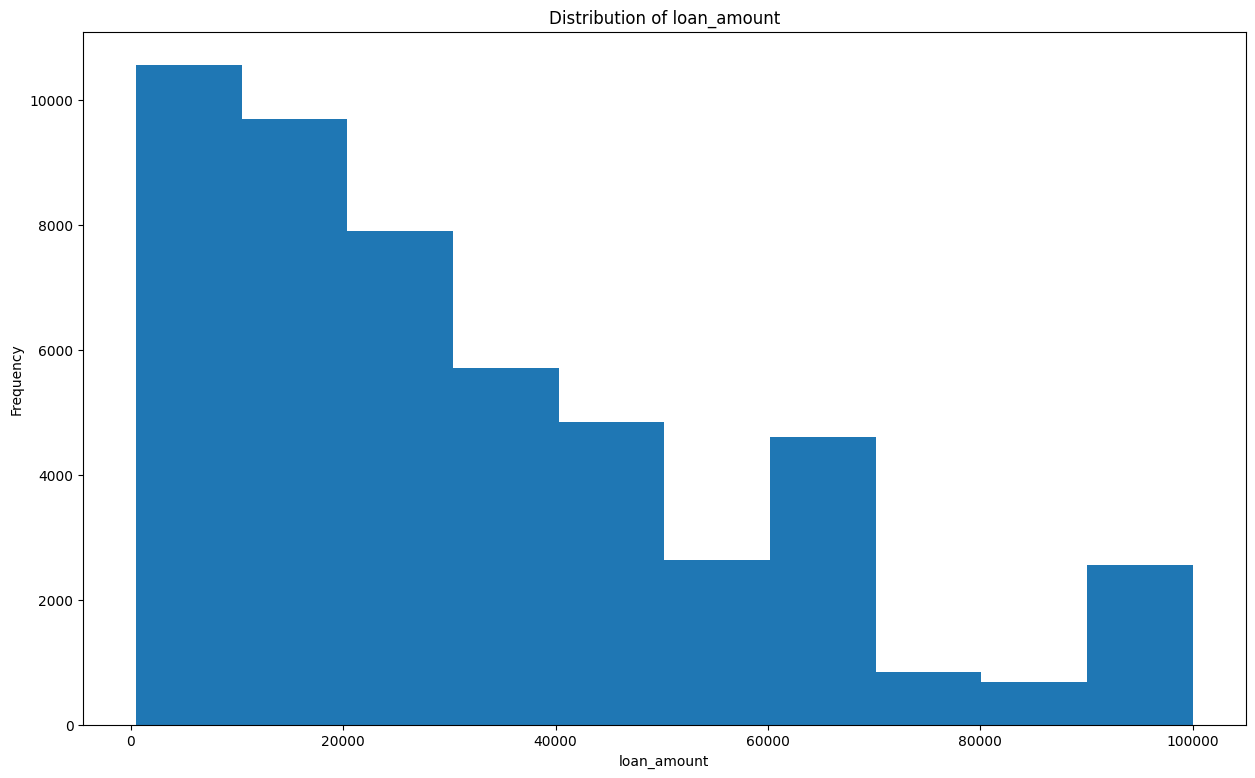

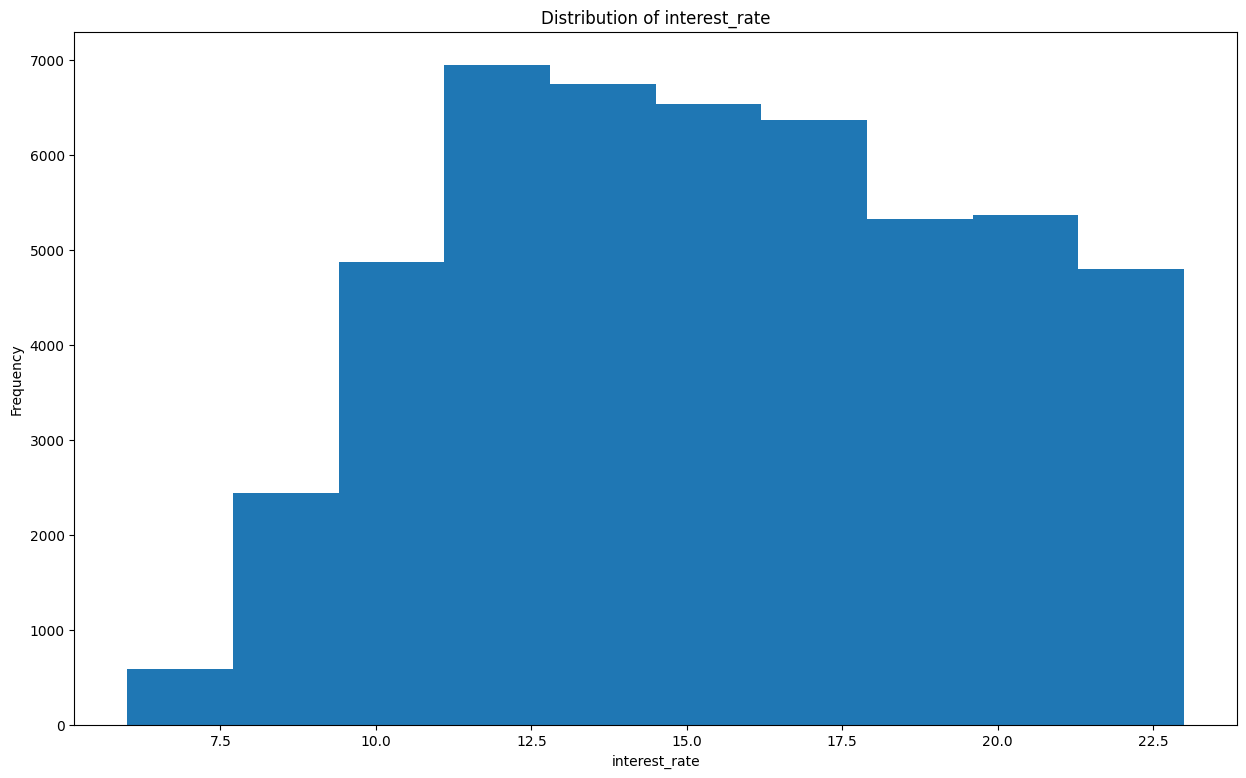

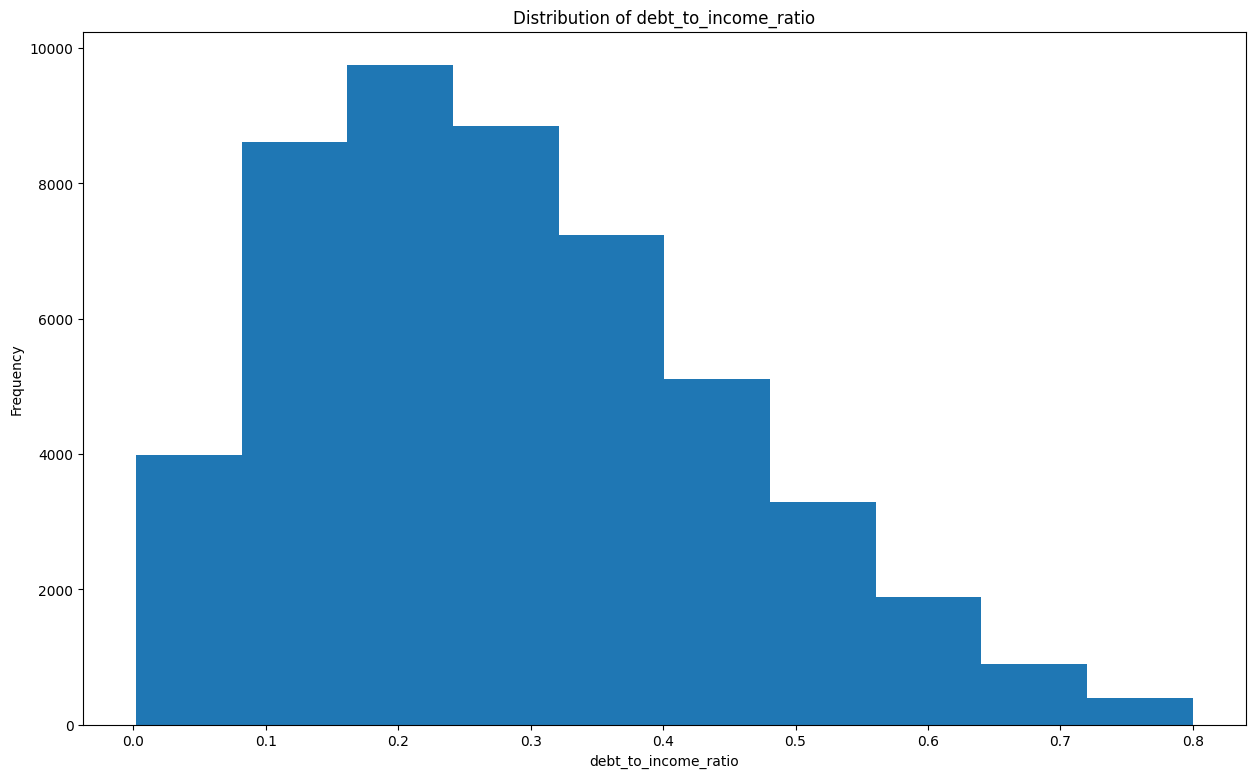

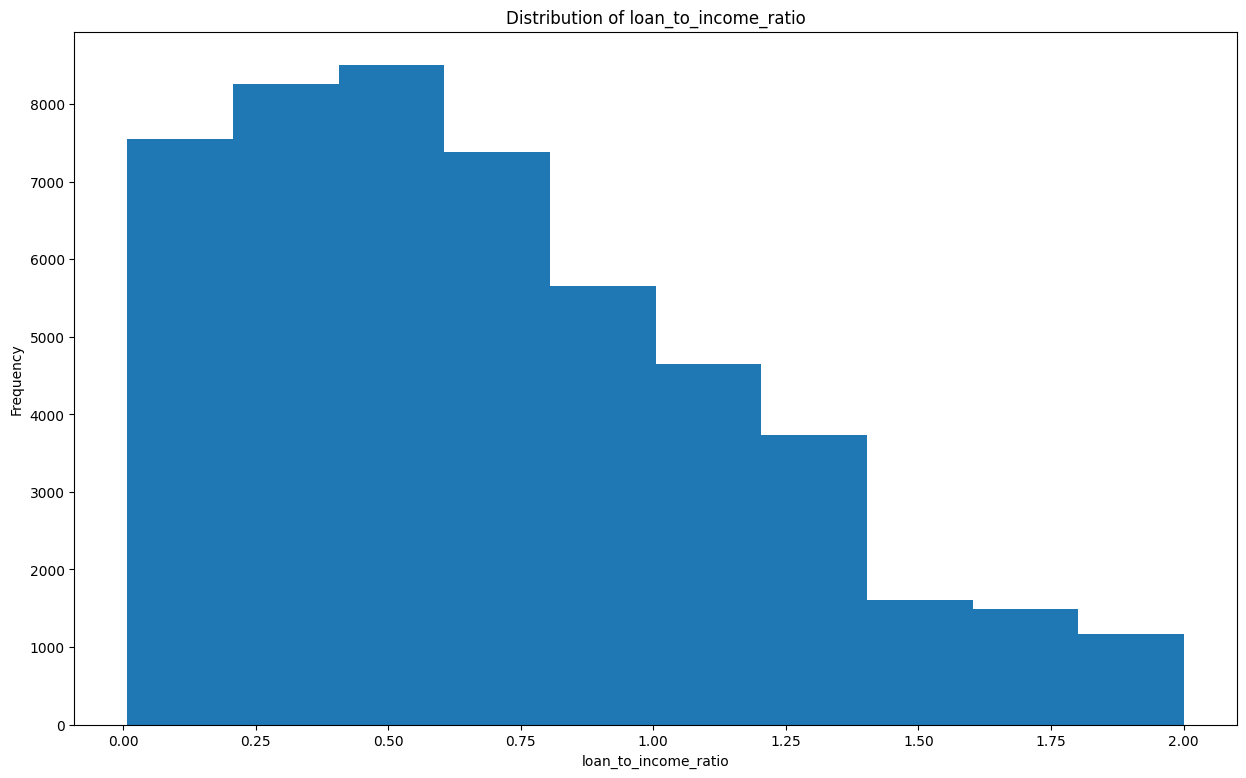

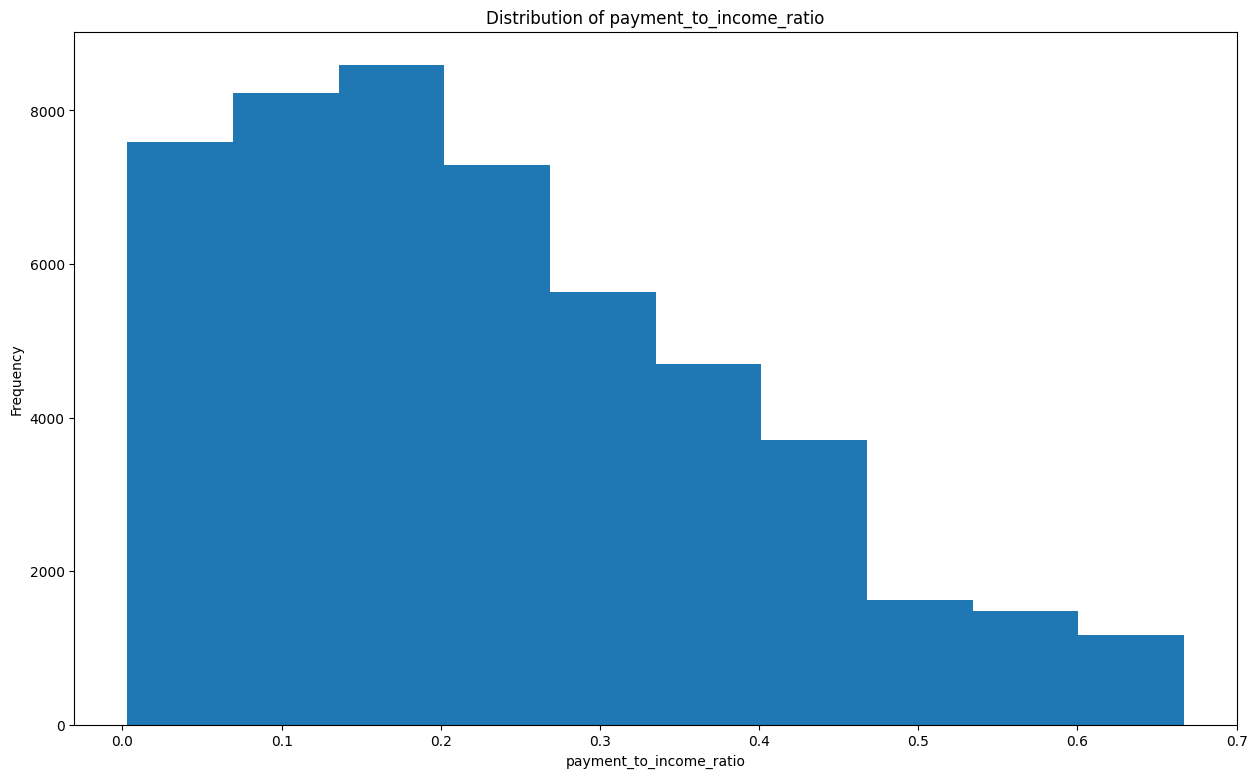

In [19]:
for col in num_cols:
    fig, ax = plt.subplots(figsize=(15,9))
    n, bins, patches = ax.hist(loan_appr_df[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {col}")

These distributions look appropriate for each category, no major changes will be required. There is no case of "normal" distributions, which for looking at human populations is expected. The only "bimodal" feature seen is `loan_status` which doesn't really count since it's the binary response variable and resembles a categorical variable, not a numeric variable.

Other non-continuous distributions are for `derogatory_marks`, `defaults_on_file`, and `delinquencies_last_2_years` are expected as these are discrete variables.

### 3. Data Cleaning

Based on what I can see in this dataset, there is very little cleaning that must take place. Instead, there simply needs to be a pipeline to create a `OneHotEncoder` for the categorical columns and `StandardScaler` for the numeric columns for use for each classifier.

At this point, I'm dropping the customer ID column because it isn't useful in classification. This may have been able to be done earlier in the process as well. An alternative treatment is to use this column as the index, rather than the existing non-semantic index.

In addition, I will adjust the dtype of the object columns to be categorical for more efficient storage of data moving forward, and to solidify the idea that they are categories that will benefit from One-Hot Encoding before training the various models.

Finally, I have removed the `payment_to_income_ratio` column because it has perfect correlation with `loan_to_income_ratio` and does not add any value to this analysis as a redundant column.

In [20]:
# Deliverables 1.1.2 and 1.1.3
def clean_dataset(orig_df: pd.DataFrame) -> pd.DataFrame:
    # remove the Customer_ID and payment_to_income_ratio columns
    loan_appr_wip = orig_df.drop(columns=['customer_id', 'payment_to_income_ratio'])
    
    # make each object feature a category feature instead
    for col in obj_cols:
        loan_appr_wip[col] = loan_appr_wip[col].astype('category')

    # save clean dataset as Parquet
    data_path = save_atomic(loan_appr_wip, Path("data/loan_approval_data_2025.clean.parquet"), fmt="parquet")
    logger.info(f"Saved the clean dataset to {data_path} {loan_appr_wip.shape}")

    return loan_appr_wip

In [21]:
loan_appr_wip = clean_dataset(loan_appr_df)

Now that cleaning is complete, let's perform a quick look at the clean DataFrame to make sure that the dtypes are correct and we still have no null values.

In [22]:
loan_appr_wip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      50000 non-null  int64   
 1   occupation_status        50000 non-null  category
 2   years_employed           50000 non-null  float64 
 3   annual_income            50000 non-null  int64   
 4   credit_score             50000 non-null  int64   
 5   credit_history_years     50000 non-null  float64 
 6   savings_assets           50000 non-null  int64   
 7   current_debt             50000 non-null  int64   
 8   defaults_on_file         50000 non-null  int64   
 9   delinquencies_last_2yrs  50000 non-null  int64   
 10  derogatory_marks         50000 non-null  int64   
 11  product_type             50000 non-null  category
 12  loan_intent              50000 non-null  category
 13  loan_amount              50000 non-null  int64   
 14  intere

Now I have to redefine the various column lists, since the WIP DataFrame is not the same as the original DataFrame.

In [23]:
# Categorical columns, currently represented as `object` (string) dtypes
obj_cols = [col for col in loan_appr_wip.dtypes[loan_appr_wip.dtypes == 'category'].index]

# all numerical columns including the `loan_status` target variable
num_cols_with_target = loan_appr_wip.drop(columns=obj_cols).columns.values

# all numerical columns excluding the `loan_status` target variable
num_cols = loan_appr_wip.drop(columns=obj_cols).drop(columns=['loan_status']).columns.values

## 4. Model Training and Selection

This section of the notebook provides the basis for the model training and selection process.

First, I will create a machine learning pipeline that includes the preprocessing steps for both the categorical (`OneHotEncoder`) and numeric (`StandardScaler`) variables. This ensures that the trained pipeline can be used for both training and inference as the same steps are being performed in both instances (provided the DataFrame columns are similar).

Finally, that machine learning pipeline will be trained using the `RandomizedSearchCV` method for hyperparameter tuning. This will take place in the inner loop of a nested cross-validation process. This will allow me to narrow in on which parameters are best for this scenario to reach the optimal hyperparameters for this dataset, while also training and testing the models on the entire dataset, with a rotating hold out fold.

In [24]:
# split the data into X and y sets, since cross-validation will produce the index splits
y = loan_appr_wip.pop('loan_status')
X = loan_appr_wip

### Training Pipeline Step 1: Preparing the Column Transformer

In [25]:
# Building a column transformer out of OneHotEncoder and StandardScaler
logger.info("Starting inference training pipeline for all models")
cat_preproc = OneHotEncoder()
logger.debug(f"Created OneHotEncoder for columns {obj_cols}")
num_preproc = StandardScaler()
logger.debug(f"Created StandardScaler for columns {num_cols}")

preproc = ColumnTransformer(
    transformers=[
        ("cat_transform", cat_preproc, obj_cols),
        ("num_transform", num_preproc, num_cols)
    ],
    remainder='drop',
    n_jobs=-1
)
logger.debug("Created ColumnTransformer for categorical and numerical preprocessing with all above columns. Any other columns will be dropped.")

### Training Pipeline Step 2: Implementing Nested Cross-Validation

In [26]:
# Deliverable 1.2.1, along with its calling function `train_ml_models`
def nested_cross_validation(pipeline: Pipeline, X: pd.DataFrame, y: pd.Series, est_name: str, param_grid: dict[str, list], trials: int = 1, outer_cv_splits: int = 5, inner_cv_splits: int = 3, random_state: int = 72925, verbose: int = 0, n_jobs: int = -1) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Using a Machine Learning Pipeline and Parameter Grid, perform nested Cross-Validation and return a DataFrame with the results.

    Please not that this function can take a LONG time to run, if the hyperparameter space is large, or if the combined number of cross-validation folds and trials is very large.

    This function has a very high time-complexity, and should only be run if you have a lot of time to spare. To put this in common terms, if we have four hyperparameters with 3 options each, we have a hyperparameter space of 

    Args:
        pipeline (sklearn.pipeline.Pipeline):
            The machine learning Pipeline that contains the preprocessed columns and the model to use.
        X (pd.DataFrame):
            The X matrix to use for training and testing, contains only the predictor variables.
        y (pd.Series):
            the y array to use for training and testing, contains only the reponse variable.
        est_name (str):
            The estimator name, for logging.
        param_grid (dict[str, list]):
            A parameter grid dictionary with the parameter names as 'model__parameter' as keys and the list of hyperparameter options as the values.
        trials (int):
            The number of cross-validation trials to perform, defaults to 1.
        outer_cv_splits (int):
            The number of cross-validation splits for each trial, defaults to 5.
        inner_cv_splits (int):
            The number of hyperparameter tuning splits for each outer cross-validation fold, defaults to 3.
        random_state (int):
            The random state to use for better comparison across models. Defaults to 72925.
        verbose (int):
            The level of verbosity to use for the GridSearchCV and cross_validate methods, defaults to 0, letting the loops show the progress.
        n_jobs (int):
            The number of processors to use to parallelize the jobs. Defaults to -1.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]:
            pd.DataFrame: a `results` DataFrame with the trial, fold, model name, F-Beta, Accuracy, Precision, ROC_AUC, and the best hyperparameters for that model.
            
            pd.DataFrame: an `all_preds` DataFrame with the per-observation metrics for each trial/fold for each model. Contains the test indices, the actual test values, and the predicted test values, along with the model name to identify each round correctly.
    """
    logger.info(f"Starting nested cross-validation for {est_name}")
    logger.info(f"Using parameter grid for GridSearchCV: {param_grid}")

    results = [] # aggregate metrics
    all_preds = [] # per-observation predictions for McNemar's test

    try:
        # inner tqdm loop showing trials, from Walters 2022
        for t in tqdm(range(trials), desc=f"{est_name} Cross Validation Trials", leave=True):
            # define Inner CV Loop for hyperparameter tuning
            inner_cv = KFold(n_splits=inner_cv_splits, shuffle=True, random_state=random_state)
            
            random_search = RandomizedSearchCV(
                pipeline,
                param_distributions=param_grid,
                n_iter=30, # number of random samples
                verbose=verbose,
                cv=inner_cv,
                n_jobs=n_jobs,
                random_state=random_state,
                error_score='raise'
            )

            # define Outer CV Loop
            outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True, random_state=random_state)

            for fold_idx, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y)),total=outer_cv.get_n_splits(),desc=f"Trial {t} - {est_name} Outer Folds",leave=True):
                # fit the model
                random_search.fit(X.iloc[train_idx], y.iloc[train_idx])
                # obtain best estimator from this fitting round
                best_model = random_search.best_estimator_

                # best model's prediction
                y_pred = best_model.predict(X.iloc[test_idx]) # type: ignore
                # the actual results
                y_true = y.iloc[test_idx]

                # store aggregate metrics
                results.append({
                    "trial": t,
                    "fold": fold_idx,
                    "model": est_name,
                    "hyperparameters": random_search.best_params_,
                    "accuracy": accuracy_score(y_true, y_pred),
                    "precision": precision_score(y_true, y_pred),
                    "fbeta": fbeta_score(y_true, y_pred, beta=0.5),
                    "roc_auc": roc_auc_score(y_true, best_model.predict_proba(X.iloc[test_idx])[:,1]) # type: ignore
                })

                # store per-observation results
                all_preds.append({
                    "trial": t,
                    "fold": fold_idx,
                    "model": est_name,
                    "test_indices": test_idx,
                    "y_true": y_true.values,
                    "y_pred": y_pred
                })
    except ConvergenceWarning as cw:
        logger.warning(f"The model {est_name} failed to converge.")
        logger.warning(cw.__traceback__)
    except FitFailedWarning as ffw:
        logger.warning(f"The model {est_name} failed to fit.")
        logger.warning(ffw.__traceback__)
    except UndefinedMetricWarning as umw:
        logger.warning(f"An undefined or invalid metric was used.")
        logger.warning(umw.__traceback__)
    except NotFittedError as nfe:
        logger.warning(f"The model {est_name} was not fitted before use.")
        logger.warning(nfe.__traceback__)
    except Exception as err:
        logger.warning(f"The model {est_name} experienced an unknown issue.")
        logger.warning(err.__traceback__)

    return pd.DataFrame(results), pd.DataFrame(all_preds)


### Training Pipeline Step 3: Define each model that will run in the comparison pipeline.

To actually perform the training and tuning, run the following code with the model dictionary as follows. This contains all of the model names, their objects, and their hyperparameter grids.

The nested cross validation function can take any number of model definitions, so long as they conform to the following schema:

```Python
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.<model_category> import <classifier>

model_definitions = [
    {
        "name": "Classifier Name",
        "pipeline": Pipeline([
            ('preprocessing', ColumnTransformer()),
            ('clf', <classifier>()) # this can be any classifier, just leave 'clf' the same name
        ]),
        "param_grid": {
            "clf__<hyperparameter>": [...],
            ["clf__<hyperparameter>": [...],]
        }
    }
]
```

In [27]:
model_definitions = [
    {
        "name": "Support Vector Machine",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', SVC(max_iter=-1,
                        random_state=72925, probability=True)) # Model step
        ]),
        "param_grid": {
            "clf__C": [10**x for x in range(-1,3)], # more reasonable C values
            "clf__kernel": ['rbf', 'poly'],
            "clf__degree": [2,3], # for 'poly' kernel only
            "clf__gamma": ['scale', 'auto'] # important for rbf kernel
        }
    },
    {
        "name": "Logistic Regression",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', LogisticRegression(penalty='l2', random_state=72925)) # Model step
        ]),
        "param_grid": {
            # C must be positive, starting with default value and moving up on log scale 4 places
            "clf__C": list(np.logspace(-4,4,4)),
            "clf__solver": ['lbfgs', 'sag', 'saga', 'newton-cholesky'],
            "clf__max_iter": [x for x in range(1000,2001,250)]
        }
    },
    {
        "name": "Gaussian Naive Bayes",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', GaussianNB()) # Model step
        ]),
        "param_grid": {
            "clf__var_smoothing": list(np.logspace(0,-9, num=100))
        }
    },
    {
        "name": "Adaptive Boosting",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', AdaBoostClassifier(random_state=72925)) # Model step
        ]),
        "param_grid": {
            "clf__n_estimators": [x for x in range(50,250,50)],
            "clf__learning_rate": [10**x for x in [-2,-1,0]]
        }
    },
    {
        "name": "Random Forest",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', RandomForestClassifier()) # Model step
        ]),
        "param_grid": {
            'clf__n_estimators': [10**x for x in range(0,4)],
            'clf__max_features': ['sqrt'],
            'clf__max_depth': [x for x in range(1,6)],
            'clf__min_samples_split': [x*2 for x in range(1,6)]
        }
    },
]

### Training Pipeline Step 4: Run `nested_cross_validation` across all models, with incremental saves during training.

This function was created in response to an issue where a model training session ended via an error after 12 hours, and I lost ALL of the scores and other data.

So now it saves incremental progress over time, with the option to clean up that progress once the final datasets are written to disk.

In [28]:
# Deliverable 1.2.1, 1.2.2, and 1.2.3
def train_ml_models(model_defs: list[dict[str, dict]], X_predictors: pd.DataFrame, y_response: pd.Series, verbose: int = 1, num_trials: int = 1, discard_saves: bool = False, output_path: str = 'data', save_path: str = 'data/_save') -> tuple[pd.DataFrame, pd.DataFrame]:
    """train_ml_models Implements the training steps and incremental backup of results after each training trial for each model.

    Args:
        model_defs (list[dict[str, dict]]):
            This is a dictionary of model definitions that requires the name, pipeline, and param_grid keys. These will be a string, Pipeline() object, and str:list dictionary, respectively.
        X_predictors (pd.DataFrame):
            The observations DataFrame with the predictor variables. The Pipeline() object should contain the required steps to adjust the data before sending it to the classifier.
        y_response (pd.Series):
            The response variable values corresponding to each observation in X by index.
        verbose (int, optional):
            The verbosity level to pass to the nested_cross_validation function. Defaults to 1.
        num_trials (int, optional):
            The number of trials to perform. Each trial is one full nested cross-validation cycle for one model. Dramatically increases training and fitting time. Defaults to 1.
        discard_saves (bool, optional):
            Whether to clean up all of the incremental saves generated during training. Turn on ONLY if all you want are the final performance and predictions datasets. Defaults to False.
        output_path (str, optional):
            A string denoting the directory relative to the project root where the final Parquet files should be located.. Defaults to 'data'.
        save_path (str, optional): 
            A string denoting the directory relative to the project root where the incremental Parquet files should be located. Defaults to 'data/_save'.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: The all_results (performance by each metric) and all_predictions (predictions, used for McNemar's test).
    """
    # test for and create the directories
    if not Path(output_path).exists():
        os.mkdir(Path(output_path).resolve())
    if not Path(save_path).exists():
        os.mkdir(Path(save_path).resolve())

    temp_files = [] # locations of checkpoint files for clearing, if needed

    # Saving in the middle of the runs
    temp_results_path = Path(os.path.join(save_path, 'model_metrics.wip.parquet'))
    temp_predictions_path = Path(os.path.join(save_path, 'model_predictions_df.wip.parquet'))

    # Final save at the very end of the run
    final_results_path = Path(os.path.join(output_path, 'model_metrics.final.parquet'))
    final_predictions_path = Path(os.path.join(output_path, 'model_predictions.final.parquet'))

    if not final_results_path.exists() or not final_predictions_path.exists():
        # Starting over, both files must be present in order to read them in
        if not temp_results_path.exists() or not temp_predictions_path.exists():
            # no files found on disk, create an empty DataFrame to start with
            # any existing files will be overwritten in the process
            all_results = pd.DataFrame()
            all_predictions = pd.DataFrame()
        else:
            # load the existing DataFrame and add to it without overwriting initially
            all_results = pd.read_parquet(temp_results_path)
            all_predictions = pd.read_parquet(temp_predictions_path)

        for model in tqdm(model_defs, desc=f"Model Training - Main Experiment Loop", leave=True):
            logger.debug(f"Training iteration with {model['name']} as the inference model.")
            
            _result, _pred = nested_cross_validation(model['pipeline'], X_predictors, y_response, model['name'], model['param_grid'], trials=num_trials, verbose=verbose)

            logger.debug(f"Results DataFrame for {model['name']} is complete with shape {_result.shape}")

            # log the specific _result DataFrame to disk for recovery purposes
            _model_results_path = Path(os.path.join(save_path, f"model_agg_results_{model['name'].lower().replace(' ', '-')}.wip.parquet"))
            _model_predictions_path = Path(os.path.join(save_path, f"model_preds_{model['name'].lower().replace(' ', '-')}.wip.parquet"))
            
            # save results to disk
            logger.info(f"Saving the results from the {model['name']} training runs to {_model_results_path} for safe-keeping.")
            save_atomic(_result, _model_results_path) # save to disk without resource competition
            temp_files.append(_model_results_path) # track location for cleaning later

            # save predictions to disk
            logger.info(f"Saving the predictions from the {model['name']} training runs to {_model_predictions_path} for safe-keeping.")
            save_atomic(_pred, _model_predictions_path) # save to disk without resource competition
            temp_files.append(_model_predictions_path) # track location for cleaning later

            # add _result to all_results
            if all_results.shape[0] == 0:
                # empty DataFrame
                all_results = _result
                logger.debug(f"Initialized all_results DataFrame from the {model['name']} _result DataFrame.")
            else:
                # concatenating to DataFrame instead
                all_results = pd.concat([all_results, _result])
                logger.debug(f"Added the {model['name']} _result DataFrame to the existing all_results DataFrame. Current shape: {all_results.shape}")
            
            # add _pred to all_predictions
            if all_predictions.shape[0] == 0:
                # empty DataFrame
                all_predictions = _pred
                logger.debug(f"Initialized all_predictions DataFrame from the {model['name']} _pred DataFrame")
            else:
                # concatenating to existing DataFrame
                all_predictions = pd.concat([all_predictions, _pred])
                logger.debug(f"Added the {model['name']} _pred DataFrame to the existing all_predictions DataFrame. Current shape: {all_predictions.shape}")
            
            # log results DataFrame to disk so that it can be recovered on failure
            logger.info(f"Saving the results from all currently completed training runs to {temp_results_path} for safe-keeping.")
            save_atomic(all_results, temp_results_path) # save to disk without resource competition
            # is saved once per model, so make sure not already in list
            if temp_results_path not in temp_files:
                temp_files.append(temp_results_path) # track location for cleaning later

            # log predictions DataFrame to disk so that it can be recovered on failure
            logger.info(f"Saving the predictions from all currently completed training runs to {temp_predictions_path} for safe-keeping.")
            save_atomic(all_predictions, temp_predictions_path) # save to disk without resource competition
            # is saved once per model, so make sure not already in list
            if temp_predictions_path not in temp_files:
                temp_files.append(temp_predictions_path) # track location for cleaning later

        # if you reach this point, CONGRATS you are done, thanks for playing!
        logger.info(f"Saving the final results of training to {final_results_path}.")
        save_atomic(all_results, final_results_path)

        logger.info(f"Saving the final predictions from training to {final_predictions_path}.")
        save_atomic(all_predictions, final_predictions_path)
    else:
        logger.info(f"Loading the final results and predictions from the last full run from disk.")
        # final results have been created, load into DataFrame and don't repeat the process
        all_results = pd.read_parquet(final_results_path)
        all_predictions = pd.read_parquet(final_predictions_path)
    
    if discard_saves:
        # VERIFY That both files are written to disk and then clear out all of the other temp files
        if final_results_path.exists() and final_predictions_path.exists():
            logger.debug("Both the final predictions and final results have been saved. Clearing temporary storage files.")
            for temp_file in temp_files:
                if temp_file != final_results_path and temp_file != final_predictions_path:
                    os.remove(Path(temp_file).resolve())
                    logger.debug(f"Removed temp file {temp_file}")
            
            # remove the temp directory
            os.rmdir(Path(save_path).resolve())
            logger.debug(f"Removed temp directory {save_path}")
    
    # this output is used for the statistical analysis with McNemar's Test
    return all_results, all_predictions

### Training Pipeline Step 5: Actually Train the Models and Gather Performance and Predictions Data

Below is the actual training run that was used for this project.

In [29]:
# Producing 1.2.2 and 1.2.3, putting 1.2.1 into action
all_results, all_predictions = train_ml_models(model_definitions, X, y, verbose=3, num_trials=1, discard_saves=False, output_path='data', save_path='data/_save')

Here is a quick proof of concept run that demonstrates how the process works. This won't save anything to disk, but will run through a **very** quick and basic training procedure to demonstrate that the code works.

In [31]:
test_definitions = [
    {
        "name": "Support Vector Machine",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', SVC(max_iter=100,
                        random_state=72925, probability=True)) # Model step
        ]),
        "param_grid": {
            "clf__C": [1.0], # more reasonable C values
            "clf__kernel": ['rbf'],
            "clf__gamma": ['scale'] # important for rbf kernel
        }
    },
    {
        "name": "Logistic Regression",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', LogisticRegression(penalty='l2', random_state=72925)) # Model step
        ]),
        "param_grid": {
            # C must be positive, starting with default value and moving up on log scale 4 places
            "clf__C": [1.0],
            "clf__solver": ['lbfgs'],
            "clf__max_iter": [1000]
        }
    },
    {
        "name": "Gaussian Naive Bayes",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', GaussianNB()) # Model step
        ]),
        "param_grid": {
            "clf__var_smoothing": [1.0]
        }
    },
    {
        "name": "Adaptive Boosting",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', AdaBoostClassifier(random_state=72925)) # Model step
        ]),
        "param_grid": {
            "clf__n_estimators": [50],
            "clf__learning_rate": [0.1]
        }
    },
    {
        "name": "Random Forest",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', RandomForestClassifier()) # Model step
        ]),
        "param_grid": {
            'clf__n_estimators': [10**x for x in range(0,2)],
            'clf__max_features': ['sqrt'],
            'clf__max_depth': [x for x in range(1,2)],
            'clf__min_samples_split': [x*2 for x in range(1,2)]
        }
    },
]

# run the small test, capture no output
_, _ = train_ml_models(test_definitions, X, y, verbose=0, num_trials=2, discard_saves=True, output_path='data/_test', save_path='data/_test/_saves')

Model Training - Main Experiment Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Support Vector Machine Cross Validation Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 0 - Support Vector Machine Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trial 1 - Support Vector Machine Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Logistic Regression Cross Validation Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 0 - Logistic Regression Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trial 1 - Logistic Regression Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Gaussian Naive Bayes Cross Validation Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 0 - Gaussian Naive Bayes Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trial 1 - Gaussian Naive Bayes Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Adaptive Boosting Cross Validation Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 0 - Adaptive Boosting Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trial 1 - Adaptive Boosting Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Random Forest Cross Validation Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 0 - Random Forest Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trial 1 - Random Forest Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

## 5. Model Assessment Using McNemar's Test

In this section, I demonstate a method for splitting the models into pairwise assignments, creating a raw table ready to perform McNemar's test, and then performing McNemar's test, placing the results in a new statistics table.

The results include both the $\chi^2$ statistic and the p-value for each pairing.


### Analysis Step 1. Examine the `all_results` and `all_predictions` DataFrames

In [32]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 4
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trial            25 non-null     int64  
 1   fold             25 non-null     int64  
 2   model            25 non-null     object 
 3   hyperparameters  25 non-null     object 
 4   accuracy         25 non-null     float64
 5   precision        25 non-null     float64
 6   fbeta            25 non-null     float64
 7   roc_auc          25 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.8+ KB


In [33]:
all_results

trial  fold                   model  \
0      0     0  Support Vector Machine   
1      0     1  Support Vector Machine   
2      0     2  Support Vector Machine   
3      0     3  Support Vector Machine   
4      0     4  Support Vector Machine   
0      0     0     Logistic Regression   
1      0     1     Logistic Regression   
2      0     2     Logistic Regression   
3      0     3     Logistic Regression   
4      0     4     Logistic Regression   
0      0     0    Gaussian Naive Bayes   
1      0     1    Gaussian Naive Bayes   
2      0     2    Gaussian Naive Bayes   
3      0     3    Gaussian Naive Bayes   
4      0     4    Gaussian Naive Bayes   
0      0     0       Adaptive Boosting   
1      0     1       Adaptive Boosting   
2      0     2       Adaptive Boosting   
3      0     3       Adaptive Boosting   
4      0     4       Adaptive Boosting   
0      0     0           Random Forest   
1      0     1           Random Forest   
2      0     2           Random Forest   
3      0     3           Random Forest   
4      0     4           Random Forest   

                                     hyperparameters  accuracy  precision  \
0  {'clf__C': 10.0, 'clf__degree': 2.0, 'clf__gam...    0.9093   0.910895   
1  {'clf__C': 10.0, 'clf__degree': 2.0, 'clf__gam...    0.9102   0.913168   
2  {'clf__C': 10.0, 'clf__degree': 2.0, 'clf__gam...    0.9119   0.918218   
3  {'clf__C': 10.0, 'clf__degree': 2.0, 'clf__gam...    0.9119   0.913479   
4  {'clf__C': 1.0, 'clf__degree': 2.0, 'clf__gamm...    0.9125   0.915600   
0  {'clf__C': 21.54434690031882, 'clf__degree': N...    0.8685   0.876357   
1  {'clf__C': 0.046415888336127774, 'clf__degree'...    0.8612   0.866124   
2  {'clf__C': 21.54434690031882, 'clf__degree': N...    0.8642   0.871493   
3  {'clf__C': 10000.0, 'clf__degree': None, 'clf_...    0.8742   0.876484   
4  {'clf__C': 10000.0, 'clf__degree': None, 'clf_...    0.8669   0.874482   
0  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.7991   0.757236   
1  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.7982   0.755429   
2  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8055   0.760515   
3  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8029   0.756306   
4  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8035   0.758029   
0  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.9172   0.909549   
1  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.9102   0.897405   
2  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.9152   0.912127   
3  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.9174   0.904301   
4  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.9124   0.905920   
0  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8631   0.851777   
1  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8571   0.844149   
2  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8599   0.845408   
3  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8634   0.847225   
4  {'clf__C': None, 'clf__degree': None, 'clf__ga...    0.8621   0.850435   

      fbeta   roc_auc  
0  0.914101  0.974569  
1  0.915589  0.973258  
2  0.918721  0.976707  
3  0.916329  0.977316  
4  0.917619  0.975054  
0  0.878701  0.947048  
1  0.869944  0.942788  
2  0.873454  0.944594  
3  0.880729  0.948397  
4  0.876410  0.945664  
0  0.787690  0.908925  
1  0.786089  0.902293  
2  0.790706  0.907311  
3  0.788090  0.909557  
4  0.788919  0.909497  
0  0.916358  0.978205  
1  0.906629  0.975931  
2  0.916580  0.978030  
3  0.913198  0.979862  
4  0.912090  0.978078  
0  0.863146  0.942213  
1  0.856388  0.942698  
2  0.857572  0.945040  
3  0.860384  0.946273  
4  0.861407  0.942053

In [34]:
all_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   trial         25 non-null     int64 
 1   fold          25 non-null     int64 
 2   model         25 non-null     object
 3   test_indices  25 non-null     object
 4   y_true        25 non-null     object
 5   y_pred        25 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.4+ KB


Here I'm examining one of the embedded arrays, in this case for `test_indices`. This is to inform the later data wrangling steps to put the DataFrame in tall format, rather than wide.

In [35]:
all_predictions.test_indices.values

array([array([   11,    14,    15, ..., 49991, 49992, 49994], shape=(10000,)),
       array([    5,     8,    10, ..., 49971, 49983, 49993], shape=(10000,)),
       array([   13,    16,    18, ..., 49987, 49997, 49998], shape=(10000,)),
       array([    0,     2,     3, ..., 49982, 49985, 49999], shape=(10000,)),
       array([    1,     4,     6, ..., 49988, 49995, 49996], shape=(10000,)),
       array([   11,    14,    15, ..., 49991, 49992, 49994], shape=(10000,)),
       array([    5,     8,    10, ..., 49971, 49983, 49993], shape=(10000,)),
       array([   13,    16,    18, ..., 49987, 49997, 49998], shape=(10000,)),
       array([    0,     2,     3, ..., 49982, 49985, 49999], shape=(10000,)),
       array([    1,     4,     6, ..., 49988, 49995, 49996], shape=(10000,)),
       array([   11,    14,    15, ..., 49991, 49992, 49994], shape=(10000,)),
       array([    5,     8,    10, ..., 49971, 49983, 49993], shape=(10000,)),
       array([   13,    16,    18, ..., 49987, 49997

In this case, the `trial` column isn't really information, as the training cycle only contained one trial to save time.

In [36]:
all_predictions = all_predictions.drop(columns=['trial'])

In [37]:
all_predictions

fold                   model  \
0     0  Support Vector Machine   
1     1  Support Vector Machine   
2     2  Support Vector Machine   
3     3  Support Vector Machine   
4     4  Support Vector Machine   
0     0     Logistic Regression   
1     1     Logistic Regression   
2     2     Logistic Regression   
3     3     Logistic Regression   
4     4     Logistic Regression   
0     0    Gaussian Naive Bayes   
1     1    Gaussian Naive Bayes   
2     2    Gaussian Naive Bayes   
3     3    Gaussian Naive Bayes   
4     4    Gaussian Naive Bayes   
0     0       Adaptive Boosting   
1     1       Adaptive Boosting   
2     2       Adaptive Boosting   
3     3       Adaptive Boosting   
4     4       Adaptive Boosting   
0     0           Random Forest   
1     1           Random Forest   
2     2           Random Forest   
3     3           Random Forest   
4     4           Random Forest   

                                        test_indices  \
0  [11, 14, 15, 17, 23, 39, 44, 49, 50, 52, 55, 6...   
1  [5, 8, 10, 19, 28, 34, 37, 38, 41, 51, 59, 70,...   
2  [13, 16, 18, 21, 22, 42, 45, 54, 57, 63, 69, 7...   
3  [0, 2, 3, 24, 25, 27, 29, 31, 47, 53, 58, 61, ...   
4  [1, 4, 6, 7, 9, 12, 20, 26, 30, 32, 33, 35, 36...   
0  [11, 14, 15, 17, 23, 39, 44, 49, 50, 52, 55, 6...   
1  [5, 8, 10, 19, 28, 34, 37, 38, 41, 51, 59, 70,...   
2  [13, 16, 18, 21, 22, 42, 45, 54, 57, 63, 69, 7...   
3  [0, 2, 3, 24, 25, 27, 29, 31, 47, 53, 58, 61, ...   
4  [1, 4, 6, 7, 9, 12, 20, 26, 30, 32, 33, 35, 36...   
0  [11, 14, 15, 17, 23, 39, 44, 49, 50, 52, 55, 6...   
1  [5, 8, 10, 19, 28, 34, 37, 38, 41, 51, 59, 70,...   
2  [13, 16, 18, 21, 22, 42, 45, 54, 57, 63, 69, 7...   
3  [0, 2, 3, 24, 25, 27, 29, 31, 47, 53, 58, 61, ...   
4  [1, 4, 6, 7, 9, 12, 20, 26, 30, 32, 33, 35, 36...   
0  [11, 14, 15, 17, 23, 39, 44, 49, 50, 52, 55, 6...   
1  [5, 8, 10, 19, 28, 34, 37, 38, 41, 51, 59, 70,...   
2  [13, 16, 18, 21, 22, 42, 45, 54, 57, 63, 69, 7...   
3  [0, 2, 3, 24, 25, 27, 29, 31, 47, 53, 58, 61, ...   
4  [1, 4, 6, 7, 9, 12, 20, 26, 30, 32, 33, 35, 36...   
0  [11, 14, 15, 17, 23, 39, 44, 49, 50, 52, 55, 6...   
1  [5, 8, 10, 19, 28, 34, 37, 38, 41, 51, 59, 70,...   
2  [13, 16, 18, 21, 22, 42, 45, 54, 57, 63, 69, 7...   
3  [0, 2, 3, 24, 25, 27, 29, 31, 47, 53, 58, 61, ...   
4  [1, 4, 6, 7, 9, 12, 20, 26, 30, 32, 33, 35, 36...   

                                              y_true  \
0  [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, ...   
1  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...   
2  [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...   
3  [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...   
4  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
0  [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, ...   
1  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...   
2  [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...   
3  [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...   
4  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
0  [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, ...   
1  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...   
2  [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...   
3  [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...   
4  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
0  [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, ...   
1  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...   
2  [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...   
3  [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...   
4  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
0  [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, ...   
1  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...   
2  [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...   
3  [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, ...   
4  [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   

                                              y_pred  
0  [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...  
1  [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, ...  
2  [1, 0, 0, 

### Analysis Step 2: Create Model Groupings for Pairwise Stats Testing

During this step, I worked on several iterations of the DataFrame manipulation to produce a predictions dataset that conforms to the format that works best for producing a contingency table.

I've kept the multiple versions of this function to show how its algorithm evolved over time, however only the final `create_mcnemar_raw_table` function is used during the analysis.

In [ ]:
# test just looking at a single pair, to produce the first two functions
test = all_predictions[all_predictions['model'].isin(['Adaptive Boosting', 'Random Forest'])]

In [ ]:
# NOT USED for this analysis, for records keeping only
# the original version, where I wasn't quite sure how to optimize
def old_create_mcnemar_raw_table(pairing_df: pd.DataFrame) -> pd.DataFrame:
    separate_dfs = []
    for model_name in pairing_df['model'].unique():
        model_df = pd.DataFrame()
        for row in pairing_df[pairing_df['model'] == model_name].iterrows():
            new_dict = {}
            for colname, item in zip(row[1].index, row[1].values):
                if colname != 'fold':
                    new_dict[colname] = item
            model_df = pd.concat([model_df, pd.DataFrame(new_dict)])

        model_df = model_df.rename(columns={'y_pred': model_name})
        model_df = model_df.drop(columns=['model'])
        model_df = model_df.sort_values(by='test_indices')
        separate_dfs.append(model_df)
    mcnemar_raw = pd.merge(separate_dfs[0], separate_dfs[1].drop(columns=['y_true']), on='test_indices')

    return mcnemar_raw

In [ ]:
# NOT USED for this analysis, for records keeping only
# optimized using .explode(), though logically equivalent to the first function
def pairwise_create_mcnemar_raw_table(pairing_df: pd.DataFrame) -> pd.DataFrame:
    separate_dfs = []
    for model_name in pairing_df['model'].unique():
        # filter to a single model type
        model_df = pairing_df[pairing_df['model'] == model_name].copy()

        # explode lists into rows
        model_df = model_df.explode(['test_indices', 'y_true', 'y_pred'])

        # rename y_pred to model name
        model_df = model_df.rename(columns={'y_pred': model_name})

        # drop model column
        model_df = model_df.drop(columns=['model'])
        separate_dfs.append(model_df)
    
    # merge on test_indices and y_true
    mcnemar_raw = pd.merge(
        separate_dfs[0].drop(columns=['fold']),
        separate_dfs[1].drop(columns=['y_true', 'fold']),
        on='test_indices'
    )
    return mcnemar_raw

In the interest of ensuring that both options work, here is a quick comparison of the first two methods, brute force `old_create_mcnemar_raw_table` vs the vectorization `pairwise_create_mcnemar_raw_table`.

In [ ]:
# This was just a quick comparison of the equivalence of these two functions, leaving here for posterity later, so I can see the evolution
mcnemar_raw = old_create_mcnemar_raw_table(test)
mcnemar_raw2 = pairwise_create_mcnemar_raw_table(test)
mcnemar_raw2 = mcnemar_raw2.sort_values(by='test_indices')
for col in mcnemar_raw.columns.values:
    col1 = mcnemar_raw[col].values
    col2 = mcnemar_raw2[col].values

    print(f"Comparing column {col}")

    if (col1 == col2).all() == True:
        print(f"Both {col} columns are identical")

This is the final version of the McNemar raw table creation algorithm, extensible to the entire `all_predictions` dataset. The previous version required filtering to a single pair of models first. This saves a little bit on processing time.

In [38]:
# optimized further by allowing all models to be treated at once, rather than only using a subset of each pairing, this should reduce the amount of space used in memory
def create_mcnemar_raw_table(predictions_df: pd.DataFrame) -> pd.DataFrame:
    """create_mcnemar_raw_table modifies the output predictions data from model training to optimize for use in creating a contingency table to complete McNemar's test.

    Specifically, the predictions data has three columns (test_indices, y_true, y_pred) that were captured as arrays on each observation. This function uses pd.DataFrame.explode() on temporary intermediate DataFrames to expand these out to be rows of their own, thus allowing easier comparison between models, and much easier calculation of the 2x2 contingency table.

    Args:
        predictions_df (pd.DataFrame):
            The predictions dataset generated from nested_cross_validation by way of train_ml_models (in this notebook).

    Returns:
        pd.DataFrame: Produces a raw data table that is easy to use directly in mlxtend.evaluate.mcnemar_table to create a contingency table.
    """
    # remove columns that are inconsequential to this part of the process, if they exist
    remove_cols = ['fold', 'trial']
    for col_name in remove_cols:
        if col_name not in predictions_df.columns.values:
            remove_cols.remove(col_name)

    # preserving the original DataFrame through copy
    preds_copy = predictions_df.drop(columns=remove_cols).copy() if len(remove_cols) > 0 else predictions_df.copy()
        
    intermediate_dfs = []
    for model_name in preds_copy['model'].unique():
        # filter to a single model type
        model_df = preds_copy[preds_copy['model'] == model_name].copy()

        # explode lists into rows
        model_df = model_df.explode(['test_indices', 'y_true', 'y_pred'])

        # rename y_pred to model name
        model_df = model_df.rename(columns={'y_pred': model_name})

        # drop model column
        model_df = model_df.drop(columns=['model'])
        intermediate_dfs.append(model_df)
    
    # merge on test_indices and y_true
    merged = intermediate_dfs[0]
    for other_df in intermediate_dfs[1:]:
        merged = pd.merge(
            merged,
            other_df.drop(columns=['y_true']),
        on='test_indices'
    )

    return merged

### Analysis Step 3: Performing McNemar's Test

This function just wraps the `mlxtend.mcnemar_table` and the `statsmodels` implementation of McNemar's test for each of calling as a utility function, or just repeated calls later in the notebook.

I used the `mlxtend.mcnemar_table` to quickly create the contingency table that's required for McNemar's test. When using McNemar's test, I also passed in the flag to use Edwards' continuity correction (`correction=True`).

Since I'm expected $b + c < 25$ to be true, I won't produce an exact p-value using the binomial distribution (`exact=False`). Instead, this implementation will use the $\chi^2$ distribution in order to produce the p-value from the $\chi^2$ statistic.

In [39]:
def run_mcnemars_test(predictions_df: pd.DataFrame) -> pd.DataFrame:
    """run_mcnemars_test generates a contingency table internally to then retrieve the stastic and p-value from McNemar's test.

    Uses the statsmodels implementation of McNemar's test. Specifically assumes that the total number of non-matching observations is greater than 25, thus using the chi-squared distribution rather than the binomial distribution. Also uses the Edwards (1948) continuity correction, which is the most common variant of this test.

    Args:
        predictions_df (pd.DataFrame):
            The predictions dataset generated from nested_cross_validation by way of train_ml_models (in this notebook).

    Returns:
        pd.DataFrame: produces a DataFrame that contains the model pairing, chi-squared statistic, and p-value from McNemar's test.
    """   
    final_stats = []

    # first manipulate the predictions_df table into a shape conducive to McNemar's test
    mcnemar_raw = create_mcnemar_raw_table(predictions_df).sort_values(by='test_indices')

    test_pairings = list(combinations(predictions_df.model.drop_duplicates(), 2))

    # This needs to be run pairwise between each pair of models
    for pairing in test_pairings:
        contingency_table = mcnemar_table(
            y_target=mcnemar_raw['y_true'], # shared target values
            y_model1=mcnemar_raw[pairing[0]], # first model in pairing
            y_model2=mcnemar_raw[pairing[1]] # second model in pairing
        )

        # compute X^2 value and p-value, store in a new statistics table
        # using the continuity correction added by Al Edwards (1948)
        mcnemar_results = mcnemar(contingency_table, correction=True, exact=False)
        
        final_stats.append({
            "modelA": pairing[0],
            "modelB": pairing[1],
            "chi2": mcnemar_results.statistic, # type: ignore this is a sklearn.utils.Bunch
            "p_value": mcnemar_results.pvalue # type: ignore this is a sklearn.utils.Bunch
        })

    stats_results = pd.DataFrame(final_stats)

    # Using Bonferroni correction of p-value for simplicity
    stats_results['alpha'] = 0.05/len(test_pairings)
    # Show whether the result is significant or not
    stats_results['significant'] = stats_results['p_value'] < stats_results['alpha']

    return stats_results

In [40]:
stats_results = run_mcnemars_test(all_predictions)

In [41]:
stats_results

modelA                modelB         chi2        p_value  \
0  Support Vector Machine   Logistic Regression   964.524554  9.236097e-212   
1  Support Vector Machine  Gaussian Naive Bayes  3325.860245   0.000000e+00   
2  Support Vector Machine     Adaptive Boosting     8.059503   4.526561e-03   
3  Support Vector Machine         Random Forest   981.946782  1.508067e-215   
4     Logistic Regression  Gaussian Naive Bayes  1219.876840  2.921035e-267   
5     Logistic Regression     Adaptive Boosting  1011.337823  6.163758e-222   
6     Logistic Regression         Random Forest    10.222553   1.387337e-03   
7    Gaussian Naive Bayes     Adaptive Boosting  3692.147299   0.000000e+00   
8    Gaussian Naive Bayes         Random Forest  1086.017937  3.612634e-238   
9       Adaptive Boosting         Random Forest  1462.353824   0.000000e+00   

   alpha  significant  
0  0.005         True  
1  0.005         True  
2  0.005         True  
3  0.005         True  
4  0.005         True  
5  0.005         True  
6  0.005         True  
7  0.005         True  
8  0.005         True  
9  0.005         True

### Analysis Step 4: Visualization of Results

First, I will produce a bar chart showing the mean and standard deviation for each metric across models. This is the standard comparison, and doesn't contain any information about whether the differences are significant.

To do so, I'll need to take the `all_results` table, drop the unnecessary columns for `trial`, `fold`, and `hyperparameters`, and then melt the DataFrame into long format, from wide.

Then, I'll update the column and metric names to produce a better, more professional display.

In [42]:
all_results_clean = all_results.drop(columns=['trial','fold','hyperparameters'])
all_results_clean = all_results_clean.melt(id_vars=['model'], value_vars=['accuracy', 'precision', 'fbeta', 'roc_auc'], var_name='metric', value_name='score')

# Replace values in the metric column with proper casing and verbiage
all_results_clean['metric'] = all_results_clean['metric'].replace('accuracy', 'Accuracy')
all_results_clean['metric'] = all_results_clean['metric'].replace('precision', 'Precision')
all_results_clean['metric'] = all_results_clean['metric'].replace('fbeta', 'F-Beta (0.5)')
all_results_clean['metric'] = all_results_clean['metric'].replace('roc_auc', 'ROC-AUC')

To actually display the bar chart, I've adjusted the y-limits to only show the uppermost part of each bar. This declutters the graph and allows for a cleaner comparison, and allows the legend to not overlap any of the bars.

Each bar actually does have an error bar, calculated using $\mu \pm \sigma$. These error bars aren't very large in this case, due to the limited sample size and the very even distribution of the data's trends across the dataset (data was not lopsided).

In [43]:
# Deliverable 1.4.3
def plot_scores_bar_chart(results: pd.DataFrame, hue_order: list[str]) -> None:
    """plot_scores_bar_chart plots the mean and standard deviation of each metric for each model, allowing comparison of the metrics by classification model.

    Args:
        results (pd.DataFrame):
            The performance dataset from nested_cross_validation by way of train_ml_models (in this notebook).
        hue_order (list[str]):
            The specific order of the models for display in each bar cluster.
    """
    # Allow the use of LaTeX formatting in Matplotlib labels
    plt.rcParams['text.usetex']

    plt.figure(figsize=(20,10))
    ax = sns.barplot(
        results,
        x='metric',
        y='score',
        hue='model',
        palette="colorblind",
        errorbar="sd",
        estimator='mean',
        legend='full',
        hue_order=hue_order
    )
    plt.title("Comparison of Models by Mean Scores")
    plt.ylim(0.7, 1.0)
    ax.set_ylabel(r'Score ($\mu \pm \sigma$)')
    ax.set_xlabel('Model Metric Name')

    # add column labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type='edge', padding=10) # type: ignore
    plt.show()

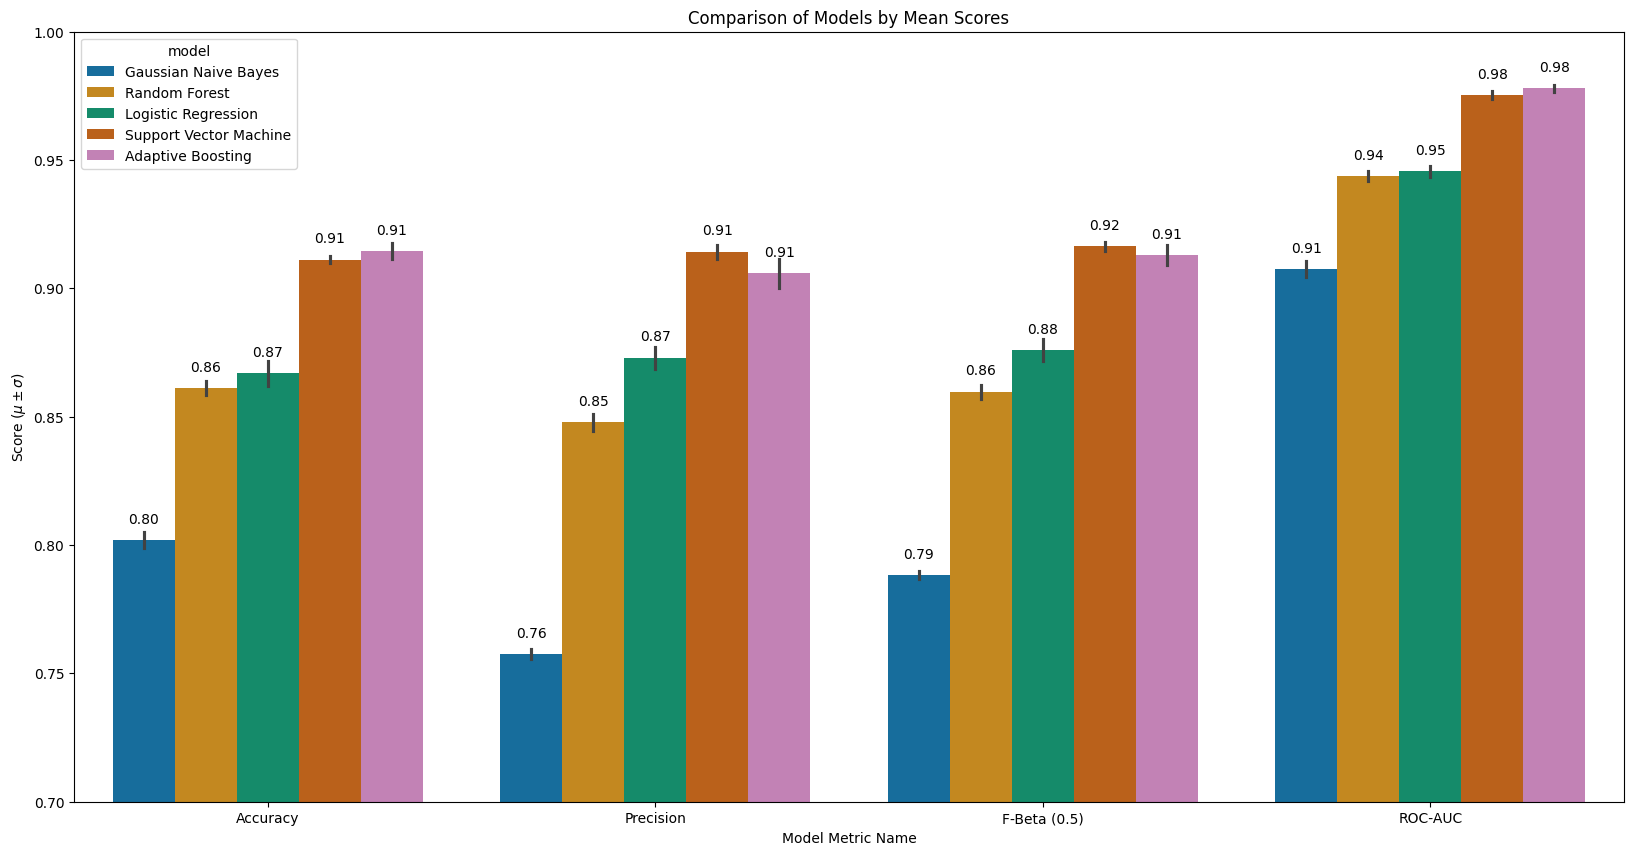

In [44]:
model_order = [
            'Gaussian Naive Bayes',
            'Random Forest',
            'Logistic Regression',
            'Support Vector Machine',
            'Adaptive Boosting'
        ]
plot_scores_bar_chart(all_results_clean, model_order)

Finally, this last function produces a heatmap showing whether the results of each application of McNemar's Test produced a significant result. Each square on the heatmap shows the actual rounded p-value from the test, and is colored based on which side of the Bonferroni adjusted significance threshold ($\alpha = \frac{\alpha}{n}$, where $\alpha = 0.05$ and $n$ is the number of comparisons made) that value ended up on. Since there are 10 comparisons, the $\alpha$ is corrected to $\alpha = \frac{0.05}{10} = 0.005$.

Since all of the $p$ values produced in this experiment are below $\alpha$, all results are significant. This is shown on the heatmap with varying shades of green. Darker green squares are well below the significance threshold, while lighter green (or white) are closer to or above the significance threshold.

In [45]:
# Deliverable 1.4.2
def plot_stats_heatmap(stats_table: pd.DataFrame) -> None:
    """plot_stats_heatmap plots the results from each application of McNemar's test, showing the p-value and whether it was below the Bonferroni corrected significance threshold.

    Args:
        stats_table (pd.DataFrame):
            The resulting table from run_mcnemars_test with each model pairing, the chi-squared statistic, and the p-value.
    """
    # first we require a symmetric matrix of p-values and models
    pivot_table = stats_table.pivot(index="modelA", columns="modelB", values="p_value")

    # takes care of the issue with half the cells being empty, leaves diagonal alone
    filled_pivot = pivot_table.combine_first(pivot_table.T)

    # Then, to show significance I'll want to use a heatmap to demonstrate which pairings were significant, and which were not
    # significance mask, whether the p-value is still significant when corrected
    significant = filled_pivot < stats_table['alpha'].values[0]

    # create annotations
    annot = filled_pivot.round(4).astype(str)
    # swap in a * to show that the value is significant after correction
    annot = annot + significant.replace({True: "*", False: ""})

    # masking the upper right half so we don't get repeats
    mask = np.triu(np.ones_like(filled_pivot, dtype=bool))

    plt.figure(figsize=(8,5))
    sns.heatmap(
        filled_pivot,
        annot=annot,
        cmap=sns.light_palette("seagreen", reverse=True, as_cmap=True),
        cbar_kws={'label':'p-value'},
        fmt="",
        mask=mask,
        center=stats_results['alpha'].values[0]
    )
    plt.title("Pairwise McNemar Test p-values (Bonferroni Corrected)")
    plt.show()

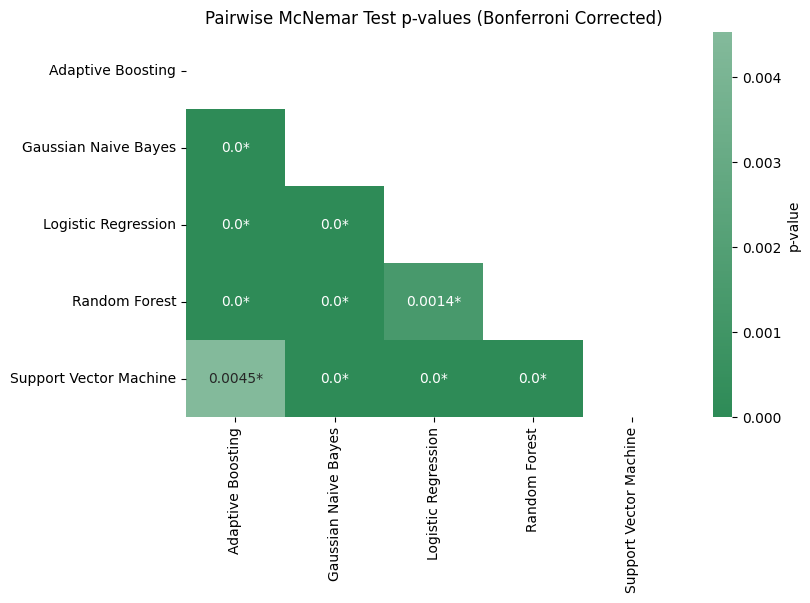

In [46]:
plot_stats_heatmap(stats_results)